In [1]:
%matplotlib notebook

from amsre_averaged_v7 import AMSREaveraged
from quikscat_daily_v4 import QuikScatDaily

import numpy as np
import sys
import netCDF4 as nc4
import matplotlib.pyplot as plt
from pycurrents.data.timetools import ddtime, day_to_dt64, dt64_to_ymdhms

# Run Functions

In [2]:
def getdates(day1, day2):
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing decimal dates (starting 1-1-1), 
    starting from day1 to day2, spacing is 1
    '''   
    day1 = ddtime(1,day1)
    day2 = ddtime(1,day2)
    time = np.arange(day1, day2+1)
    return time

def timearr(day1,day2): #day1 = '2009/01/01 00:00:00',day2 = '2009/01/31 00:00:00'):   
    '''
    Parameters: First and Last Date in Form yyyy/mm/dd hh:mm:ss'
    
    Return: array containing str dates in form yyyymmd, it includes every
    day from day1 to day2
    '''  
    tarr = getdates(day1,day2)
    t = day_to_dt64(1,tarr)
    t = dt64_to_ymdhms(t)
    ttt = ['','','']
    tttt = np.empty(len(t), dtype=int)   
    for i in range(len(t)):
        tt = t[i] 
        #delete hh,mm, and ss column
        tt = np.delete(tt,5,0)
        tt = np.delete(tt,4,0)
        tt = np.delete(tt,3,0)

        #ensures mm and dd have two didgits (e.g. 1 is 01)
        if tt[1] < 10:
            ttt[1] = ('0' + str(tt[1]))
        else:
            ttt[1] = str(tt[1])          
        if tt[2] < 10:
            ttt[2] = ('0' + str(tt[2]))
        else:
            ttt[2] = str(tt[2])      
    
        ttt[0] = str(tt[0])
        tttt[i] = ''.join(ttt)      
    tttt = list(map(str, tttt))   
    return tttt



In [3]:
t_str = timearr('2003/01/01 00:00:00','2008/12/31 00:00:00')
day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
dt64 = day_to_dt64(1,day)
ymdhms = dt64_to_ymdhms(dt64)

In [4]:
def monthly_avg(data, time):
    '''
    Function allows you to average data by each month.

    Paramaters: data to average and time in decimal form
    Returns: (1) data averaged by each month and (2) year and month
    '''

    t = day_to_dt64(1,time)
    ymdhms = dt64_to_ymdhms(t)
    
    ym = ymdhms[:,0:2]
    y = ymdhms[:,0]
    m = ymdhms[:,1]
    
    #get unique values of [year, month]
    ym_uniq, idx = np.unique(ym,return_index=True,axis=0)
    
    #divide data where the months changee
    idx = np.append(idx, len(ym)+1)
    mmean = [np.nanmean(data[idx[i]:idx[i+1]-1,:,:]) for i in range(len(idx)-1)]
    
    #split data based on where the month changes
    split = np.split(data, idx, axis = 0)
    
    #makes string mm/yyyy for plotting purposes
    m_str = [str(ym_uniq[i,0]) + '/' + str(ym_uniq[i,1]) for i in range(len(ym_uniq[:,0]))] 
     
    return mmean, ym, m_str



In [5]:
def seasonal_avg(data,ym):
    '''
    Takes seasonal average of the entire data set, combining the years together to 
    produce a 4 separate data arrays that have a spatial represention for each season. 
    '''
    data_DJF = data[(ym[:,1] == 12) | (ym[:,1] == 1) | (ym[:,1] == 2),:,:]

    data_MAM = data[(ym[:,1] == 3) | (ym[:,1] == 4) | (ym[:,1] == 5),:,:]

    data_JJA = data[(ym[:,1] == 6) | (ym[:,1] == 7) | (ym[:,1] == 8),:,:]

    data_SON = data[(ym[:,1] == 9) | (ym[:,1] == 10) | (ym[:,1] == 11),:,:]

    DJF_avg = np.nanmean(data_DJF,axis=0)
    MAM_avg = np.nanmean(data_MAM,axis=0)
    JJA_avg = np.nanmean(data_JJA,axis=0)
    SON_avg = np.nanmean(data_SON,axis=0)
    
    return DJF_avg, MAM_avg, JJA_avg, SON_avg


In [6]:
def seasonal_avg2(data,ym,dimension=None):
    '''
    Takes seasonal average for each year. Does not combine the years together.
    Winter season includes december from the previous year. 
    Ex: DJF could be 12/2002, 1/2003, and 2/2003
    
    ym = [year, month] [year, month] ... shaped arrays that are the same 
    length as the first indice of the data array. Can obtain in monthly_avg function.
    
    '''
    
    #create indexing that isolates years from December of previous year to November
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)
    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0])-1)
    #subtract by 31 to include December from the previous year
    idx = idx-31
    #turn first index into 0 so it doesnt pull december from a different year
    idx[0]=0
    
    #get number of years for appending purposes in loop
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)

    
    #initialize
    size = [ylen,data.shape[1],data.shape[2]]
    DJF_avg2D = np.empty(size)
    MAM_avg2D = np.empty(size)
    JJA_avg2D = np.empty(size)
    SON_avg2D = np.empty(size)
    
    DJF_avg = np.empty(ylen)
    MAM_avg = np.empty(ylen)
    JJA_avg = np.empty(ylen)
    SON_avg = np.empty(ylen)    
    
    for i in range(ylen):
        #isolates time array and data by each year
        ymtemp = ym[idx[i]:idx[i+1],1]
        datatemp = data[idx[i]:idx[i+1],:,:]
        
        #isolates data by seasons, still in 3D arrays
        data_DJF = datatemp[(ymtemp == 12) | (ymtemp == 1) | (ymtemp == 2),:,:]
        data_MAM = datatemp[(ymtemp == 3) | (ymtemp == 4) | (ymtemp == 5),:,:]
        data_JJA = datatemp[(ymtemp == 6) | (ymtemp == 7) | (ymtemp == 8),:,:]
        data_SON = datatemp[(ymtemp == 9) | (ymtemp == 10) | (ymtemp == 11),:,:]
        
        if dimension == "2D":
            
            DJF_avg2D[i,:,:] = np.nanmean(data_DJF,axis=0)
            MAM_avg2D[i,:,:] = np.nanmean(data_MAM,axis=0)
            JJA_avg2D[i,:,:] = np.nanmean(data_JJA,axis=0)
            SON_avg2D[i,:,:] = np.nanmean(data_SON,axis=0)
            
        elif dimension == "1D":
            DJF_avg[i] = np.nanmean(data_DJF)
            MAM_avg[i] = np.nanmean(data_MAM)
            JJA_avg[i] = np.nanmean(data_JJA)
            SON_avg[i] = np.nanmean(data_SON)
         
        else:
            print("Select a dimension to average over. Choose either '1D' or '2D'")
        
    print("December of", y[0]-1,"is not included in DJF for",y[0])
    
    if dimension == "2D":
        return DJF_avg2D, MAM_avg2D, JJA_avg2D, SON_avg2D, y
    elif dimension == "1D":
        return DJF_avg, MAM_avg, JJA_avg, SON_avg, y


In [7]:
def annual_avg(data,ym,dimension=None):
    
    #finds the index of where the year changes and creates array of the years
    y,idx = np.unique(ym[:,0],return_index=True,axis=0)

    #add on the last index to idx for ease when indexing in loop
    idx = np.append(idx,len(ym[:,0]))
    
    ylen = y[-1]-y[0]+1
    ylen = np.int(ylen)
    
    data_avg1D = np.empty(ylen)
    data_avg2D = np.empty([ylen,data.shape[1],data.shape[2]])

    
    for i in range(ylen):
        if dimension == "1D":
            data_avg1D[i] = np.nanmean(data[idx[i]:idx[i+1]]) 
        elif dimension == "2D":
            data_avg2D[i,:,:] = np.nanmean(data[idx[i]:idx[i+1]],axis=0)

    if dimension == "1D":
        return data_avg1D,y
        
    elif dimension == "2D":
        return data_avg2D,y


In [8]:
def custom_div_cmap(numcolors=11, name='custom_div_cmap',
                    mincol='blue', midcol='white', maxcol='red'):
    """ Create a custom diverging colormap with three colors
    
    Default is blue to white to red with 11 colors.  Colors can be specified
    in any way understandable by matplotlib.colors.ColorConverter.to_rgb()
    """

    from matplotlib.colors import LinearSegmentedColormap 
    
    cmap = LinearSegmentedColormap.from_list(name=name, 
                                             colors =[mincol, midcol, maxcol],
                                             N=numcolors)
    return cmap

#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5, cmap=custom_div_cmap(mincol='#1b7837', maxcol='#762a83'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('Blues'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu_r'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('RdBu'))
#pc = ax.pcolormesh(lonAsmooth,latAsmooth,Q5,cmap=plt.cm.get_cmap('seismic'),vmin=-40, vmax=40)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='0.4', linewidths=1)
#ax.contour(lonAsmooth,latAsmooth,Q5,[0],colors='white', linewidths=1)

In [9]:
def data_slice(latpt,lonpt,data,lat,lon):

    indi = find_nearest(lat, latpt[0])
    indf = find_nearest(lat, latpt[1])
    sl = np.arange(indi, indf)
    latsl = lat[sl]

    indi2 = find_nearest(lon,lonpt[0])
    indf2 = find_nearest(lon, lonpt[1])
    sl = np.arange(indi2, indf2)
    lonsl = lon[sl]
    
    if data.ndim == 2:
        datasl = data[indi:indf, indi2:indf2]
    elif data.ndim == 3:
        datasl = data[:,indi:indf, indi2:indf2]
    
    return latsl, lonsl, datasl

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx#, array[idx]

In [11]:
#got from Air_Temp document

def get_regions(N,region):
    N=N*0.25*0.5
    
    if region == 'A':

        #Agulhas (S to S and E to E)
        latERpt = [-51-(N-0.25),-32+(N+0.25)]
        lonERpt = [5-(N-0.25),80+(N+0.25)]
        latER,lonER,UER = data_slice(latERpt,lonERpt,U)
        _,_,VER = data_slice(latERpt,lonERpt,V)
        _,_,sstER = data_slice(latERpt,lonERpt,sst5)        
        wspdER = np.sqrt(np.add(np.square(UER),np.square(VER)))
        _,_,sphER = data_slice(latERpt,lonERpt,SPH)
   
        return latER,lonER,VER,UER,wspdER,sstER,sphER

    elif region == 'GS':
        #Gulf Stream (36 N to 47.75 N and 289 W to 323.75 W)
        latWBCpt = [36-(N-0.25),47.75+(N+0.25)]
        lonWBCpt = [-71-(N-0.25),-36.25+(N+0.25)]
        latWBC,lonWBC,UWBC = data_slice(latWBCpt,lonWBCpt,U)
        _,_,VWBC = data_slice(latWBCpt,lonWBCpt,V)
        _,_,sstWBC = data_slice(latWBCpt,lonWBCpt,sst5)
        wspdWBC = np.sqrt(np.add(np.square(UWBC),np.square(VWBC)))
        _,_,sphWBC = data_slice(latWBCpt,lonWBCpt,SPH)
        
        return latWBC,lonWBC,VWBC,UWBC,wspdWBC,sstWBC,sphWBC

    elif region == 'K':
        #Kuroshio (120 E to 180 E and 26 to 48 N)
        latKpt = [24-(N-0.25),48+(N+0.25)]
        lonKpt = [135-(N-0.25),180+(N+0.25)]
        latK,lonK,UK = data_slice(latKpt,lonKpt,U)
        _,_,VK = data_slice(latKpt,lonKpt,V)
        _,_,sstK = data_slice(latKpt,lonKpt,sst5)
        wspdK = np.sqrt(np.add(np.square(UK),np.square(VK)))
        _,_,sphK = data_slice(latKpt,lonKpt,SPH)

        return latK,lonK,VK,UK,wspdK,sstK,sphK

    else:
        return 'Choose either region K, A, or GS'

In [ ]:
def calculate_QL(SST,U):
    '''
    Description: calculates Latent Heat
    
    Parameters: Sea Surface Temperature and Wind Speed
    '''
    
    #guesstimated constants:
    p = 1026.8 #hPa
    Md = 28.97 #g
    Mw = 18.016 #g
    rho = 1.178
    Lv = 2500000
    Ce = .001
    
    #calculates saturation humidity (qs) from saturation vapor pressure (e)
    
    e = 6.1094*np.exp((17.625*SST)/(SST + 243.04))
    ep = e/p
    qs = (Mw*ep)/(Md - Md*ep + Mw*ep)
    qa = 0.7*qs #estimation
    
    #calculates Evaporation
    E = rho*Ce*U*(qs-qa)
    
    #calculates Latent Heat
    QL = Lv*E
    
    return QL  #W/m^2

# Read in Data

In [27]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/KuroshioN29Qa_RH.nc','r')
grp = f.groups['Regional_data']

lon_K = grp.variables['Longitude'][23:180]
lat_K = grp.variables['Latitude'][47:79]
time = grp.variables['Time'][:]

wspd_K = grp.variables['Wind Speed'][:,47:79,23:180]
wspdsm_K =grp.variables['Wind Speed Smooth'][:,47:79,23:180]
wdir_K = grp.variables['Wind Direction'][:,47:79,23:180]
wdirsm_K = grp.variables['Wind Direction Smooth'][:,47:79,23:180]
sst_K = grp.variables['Sea Surface Temperature'][:,47:79,23:180]
sstsm_K = grp.variables['Sea Surface Temperature Smooth'][:,47:79,23:180]
sph_K = grp.variables['Specific Humidity'][:,47:79,23:180]
sphsm_K = grp.variables['Specific Humidity Smooth'][:,47:79,23:180]
rh_K = grp.variables['Relative Humidity'][:,47:79,23:180]
rhsm_K = grp.variables['Relative Humidity Smooth'][:,47:79,23:180]

Q_K = grp.variables['Latent Heat Flux Observational (Q)'][:,47:79,23:180]
Q1_K = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,47:79,23:180]
Q4_K = grp.variables['Clausius Clapeyron (Q4)'][:,47:79,23:180]
Q5_K = grp.variables['Covariability of SST and U (Q5)'][:,47:79,23:180]
Q6_K = grp.variables['Covariability of U and SPH (Q6)'][:,47:79,23:180]
Q7_K = grp.variables['Covariability of SST and SPH (Q7)'][:,47:79,23:180]

UT_K = grp.variables["U'T'"][:,47:79,23:180]
UH_K = grp.variables["U'H'"][:,47:79,23:180]
T2_K = grp.variables["T'^2'"][:,47:79,23:180]

sststd_K = grp.variables['Standard Deviation of SST'][:,47:79,23:180]
sphstd_K = grp.variables['Standard Deviation of SPH'][:,47:79,23:180]
ustd_K = grp.variables['Standard Deviation of Wind Speed'][:,47:79,23:180]

#QDTDT_K = grp.variables["LHF Second Derivative with respect to SST'"][:,47:79,23:180]
#QDUDT_K = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,47:79,23:180]
#QDUDH_K = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,47:79,23:180]

f.close()

In [14]:
print(lat_K[0])
print(lat_K[-1])
print(lon_K[0])
print(lon_K[-1])

35.75
43.5
140.75
179.75


In [15]:
t_str = timearr('2003/01/01 00:00:00','2008/12/31 00:00:00')
day = getdates('2003/01/01 00:00:00','2008/12/31 00:00:00')
dt64 = day_to_dt64(1,day)
ymdhms = dt64_to_ymdhms(dt64)

In [16]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/GulfStreamN29Qa_RH.nc','r')
grp = f.groups['Regional_data']

#print(f)
#print(grp)
lon_GS = grp.variables['Longitude'][:]
lat_GS = grp.variables['Latitude'][:]

wspd_GS = grp.variables['Wind Speed'][:,:,:]
wspdsm_GS =grp.variables['Wind Speed Smooth'][:,:,:]
wdir_GS = grp.variables['Wind Direction'][:,:,:]
wdirsm_GS = grp.variables['Wind Direction Smooth'][:,:,:]
sst_GS = grp.variables['Sea Surface Temperature'][:,:,:]
sstsm_GS = grp.variables['Sea Surface Temperature Smooth'][:,:,:]
sph_GS = grp.variables['Specific Humidity'][:,:,:]
sphsm_GS = grp.variables['Specific Humidity Smooth'][:,:,:]
rh_GS = grp.variables['Relative Humidity'][:,:,:]
rhsm_GS = grp.variables['Relative Humidity Smooth'][:,:,:]

Q_GS = grp.variables['Latent Heat Flux Observational (Q)'][:,:,:]
Q1_GS = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,:,:]
Q4_GS = grp.variables['Clausius Clapeyron (Q4)'][:,:,:]
Q5_GS = grp.variables['Covariability of SST and U (Q5)'][:,:,:]
Q6_GS = grp.variables['Covariability of U and SPH (Q6)'][:,:,:]
Q7_GS = grp.variables['Covariability of SST and SPH (Q7)'][:,:,:]

UT_GS = grp.variables["U'T'"][:,:,:]
UH_GS = grp.variables["U'H'"][:,:,:]
T2_GS = grp.variables["T'^2'"][:,:,:]

sststd_GS = grp.variables['Standard Deviation of SST'][:,:,:]
sphstd_GS = grp.variables['Standard Deviation of SPH'][:,:,:]
ustd_GS = grp.variables['Standard Deviation of Wind Speed'][:,:,:]

#QDTDT_GS = grp.variables["LHF Second Derivative with respect to SST'"][:,:,:]
#QDUDT_GS = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,:,:]
#QDUDH_GS = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,:,:]

f.close()

In [17]:
print(lat_GS[0])
print(lat_GS[-1])
print(lon_GS[0])
print(lon_GS[-1])

36.0
47.75
289.0
323.75


In [18]:
f = nc4.Dataset('/Users/baileydonaldson/python/plot_heat_flux/AgulhasN29Qa_RH.nc','r')
grp = f.groups['Regional_data']

#print(f)
#print(grp)
lon_A = grp.variables['Longitude'][25:213]
lat_A = grp.variables['Latitude'][26:50]

wspd_A = grp.variables['Wind Speed'][:,26:50,25:213]
wspdavg_A =grp.variables['Wind Speed Smooth'][:,26:50,25:213]
wdir_A = grp.variables['Wind Direction'][:,26:50,25:213]
wdirsm_A = grp.variables['Wind Direction Smooth'][:,26:50,25:213]
sst_A = grp.variables['Sea Surface Temperature'][:,26:50,25:213]
sstsm_A = grp.variables['Sea Surface Temperature Smooth'][:,26:50,25:213]
sph_A = grp.variables['Specific Humidity'][:,26:50,25:213]
sphsm_A = grp.variables['Specific Humidity Smooth'][:,26:50,25:213]
rh_A = grp.variables['Relative Humidity'][:,26:50,25:213]
rhsm_A = grp.variables['Relative Humidity Smooth'][:,26:50,25:213]

Q_A = grp.variables['Latent Heat Flux Observational (Q)'][:,26:50,25:213]
Q1_A = grp.variables['Latent Heat Flux Large Scale (Q1)'][:,26:50,25:213]
Q4_A = grp.variables['Clausius Clapeyron (Q4)'][:,26:50,25:213]
Q5_A = grp.variables['Covariability of SST and U (Q5)'][:,26:50,25:213]
Q6_A = grp.variables['Covariability of U and SPH (Q6)'][:,26:50,25:213]
Q7_A = grp.variables['Covariability of SST and SPH (Q7)'][:,26:50,25:213]

UT_A = grp.variables["U'T'"][:,26:50,25:213]
UH_A = grp.variables["U'H'"][:,26:50,25:213]
T2_A = grp.variables["T'^2'"][:,26:50,25:213]

sststd_A = grp.variables['Standard Deviation of SST'][:,26:50,25:213]
sphstd_A = grp.variables['Standard Deviation of SPH'][:,26:50,25:213]
ustd_A = grp.variables['Standard Deviation of Wind Speed'][:,26:50,25:213]

#QDTDT_A = grp.variables["LHF Second Derivative with respect to SST'"][:,26:50,25:213]
#QDUDT_A = grp.variables["LHF Second Derivative with respect to SST' and U'"][:,26:50,25:213]
#QDUDH_A = grp.variables["LHF Second Derivative with respect to U' and SPH'"][:,26:50,25:213]

f.close()

In [19]:
print(lat_A[0])
print(lat_A[-1])
print(lon_A[0])
print(lon_A[-1])

-44.5
-38.75
11.25
58.0


In [83]:
p = 1026.8 #hPa
Md = 28.97 #g
Mw = 18.016 #g
rho = 1.178
Lv = 2500000
Ce = .001
    
#calculates saturation humidity (qs) from saturation vapor pressure (e)
    
e = 6.1094*np.exp((17.625*sst_GS)/(sst_GS + 243.04))
ep = e/p
qs_GS = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sst_K)/(sst_K + 243.04))
ep = e/p
qs_K = (Mw*ep)/(Md - Md*ep + Mw*ep)

e = 6.1094*np.exp((17.625*sst_A)/(sst_A + 243.04))
ep = e/p
qs_A = (Mw*ep)/(Md - Md*ep + Mw*ep)



In [84]:
print(np.nanmean(sph_GS/qs_GS))
print(np.nanmean(sph_K/qs_K))
print(np.nanmean(sph_A/qs_A))

0.6875082
0.67761123
0.6861217


## Calulate Mean, Max, and Min

In [20]:
print('Q mean',np.nanmean(Q_A))
print('Q max',np.nanmax(Q_A))
print('95% Q Agulhas: ',np.nanpercentile(Q_A,95))
print('Q min',np.nanmin(Q_A))
print('5% Q Agulhas: ',np.nanpercentile(Q_A,5))

print('Q4 mean',np.nanmean(Q4_A))
print('Q4 max',np.nanmax(Q4_A))
print('95% Q4 Agulhas: ',np.nanpercentile(Q4_A,95))
print('Q4 min',np.nanmin(Q4_A))
print('5% Q4 Agulhas: ',np.nanpercentile(Q4_A,5))

print('Q5 mean',np.nanmean(Q5_A))
print('Q5 max',np.nanmax(Q5_A))
print('95% Q5 Agulhas: ',np.nanpercentile(Q5_A,95))
print('Q5 min',np.nanmin(Q5_A))
print('5% Q5 Agulhas: ',np.nanpercentile(Q5_A,5))


print('Q6 mean',np.nanmean(Q6_A))
print('Q6 max',np.nanmax(Q6_A))
print('95% Q6 Agulhas: ',np.nanpercentile(Q6_A,95))
print('Q6 min',np.nanmin(Q6_A))
print('5% Q6 Agulhas: ',np.nanpercentile(Q6_A,5))

print('Q7 mean',np.nanmean(Q7_A))
print('Q7 max',np.nanmax(Q7_A))
print('95% Q7 Agulhas: ',np.nanpercentile(Q7_A,95))
print('Q7 min',np.nanmin(Q7_A))
print('5% Q7 Agulhas: ',np.nanpercentile(Q7_A,5))

Q mean 74.26344
Q max 418.02133
95% Q Agulhas:  177.97617416381834
Q min -88.1314
5% Q Agulhas:  1.6181147456169132
Q4 mean 1.6566007
Q4 max 12.440997
95% Q4 Agulhas:  4.322747898101806
Q4 min -5.061535
5% Q4 Agulhas:  -0.057465414516627775
Q5 mean -0.94665444
Q5 max 23.474102
95% Q5 Agulhas:  3.4722416043281554
Q5 min -19.057205
5% Q5 Agulhas:  -5.903542447090149
Q6 mean 0.6686254
Q6 max 21.240364
95% Q6 Agulhas:  5.467136216163634
Q6 min -20.980417
5% Q6 Agulhas:  -2.962936282157898
Q7 mean 3.9232068
Q7 max 35.894722
95% Q7 Agulhas:  11.237985467910766
Q7 min -12.711512
5% Q7 Agulhas:  -1.3744311571121213


In [21]:
print('Q mean',np.nanmean(Q_GS))
print('Q max',np.nanmax(Q_GS))
print('95% Q max GS: ',np.nanpercentile(Q_GS,95))
print('Q min',np.nanmin(Q_GS))
print('5% Q GS: ',np.nanpercentile(Q_GS,5))

print('Q4 mean',np.nanmean(Q4_GS))
print('Q4 max',np.nanmax(Q4_GS))
print('95% Q4 max GS: ',np.nanpercentile(Q4_GS,95))
print('Q4 min',np.nanmin(Q4_GS))
print('5% Q4 GS: ',np.nanpercentile(Q4_GS,5))

print('Q5 mean',np.nanmean(Q5_GS))
print('Q5 max',np.nanmax(Q5_GS))
print('95% Q5 max GS: ',np.nanpercentile(Q5_GS,95))
print('Q5 min',np.nanmin(Q5_GS))
print('5% Q5 GS: ',np.nanpercentile(Q5_GS,5))

print('Q6 mean',np.nanmean(Q6_GS))
print('Q6 max',np.nanmax(Q6_GS))
print('95% Q6 max GS: ',np.nanpercentile(Q6_GS,95))
print('Q6 min',np.nanmin(Q6_GS))
print('5% Q6 GS: ',np.nanpercentile(Q6_GS,5))

print('Q7 mean',np.nanmean(Q7_GS))
print('Q7 max',np.nanmax(Q7_GS))
print('95% Q7 max GS: ',np.nanpercentile(Q7_GS,95))
print('Q7 min',np.nanmin(Q7_GS))
print('5% Q7 GS: ',np.nanpercentile(Q7_GS,5))


Q mean 101.376564
Q max 555.2944
95% Q max GS:  236.814443206787
Q min -111.19582
5% Q GS:  14.480023336410524
Q4 mean 1.4613142
Q4 max 31.218744
95% Q4 max GS:  6.244159364700314
Q4 min -13.925527
5% Q4 GS:  0.031633111648261554
Q5 mean 0.10041056
Q5 max 35.84076
95% Q5 max GS:  4.479281497001646
Q5 min -23.426462
5% Q5 GS:  -3.76487785577774
Q6 mean 0.07214874
Q6 max 28.623411
95% Q6 max GS:  5.086168646812431
Q6 min -40.803905
5% Q6 GS:  -4.8309105157852175
Q7 mean 2.9027102
Q7 max 81.584404
95% Q7 max GS:  13.581699800491323
Q7 min -16.478832
5% Q7 GS:  -1.5835562884807586


In [28]:
print('Q mean',np.nanmean(Q_K))
print('Q max',np.nanmax(Q_K))
print('95% Q Kuroshio: ',np.nanpercentile(Q_K,95))
print('Q min',np.nanmin(Q_K))
print('5% Q Kuroshio: ',np.nanpercentile(Q_K,5))

print('Q4 mean',np.nanmean(Q4_K))
print('Q4 max',np.nanmax(Q4_K))
print('95% Q4 Kuroshio: ',np.nanpercentile(Q4_K,95))
print('Q4 min',np.nanmin(Q4_K))
print('5% Q4 Kuroshio: ',np.nanpercentile(Q4_K,5))

print('Q5 mean',np.nanmean(Q5_K))
print('Q5 max',np.nanmax(Q5_K))
print('95% Q5 Kuroshio: ',np.nanpercentile(Q5_K,95))
print('Q5 min',np.nanmin(Q5_K))
print('5% Q5 Kuroshio: ',np.nanpercentile(Q5_K,5))

print('Q6 mean',np.nanmean(Q6_K))
print('Q6 max',np.nanmax(Q6_K))
print('95% Q6 Kuroshio: ',np.nanpercentile(Q6_K,95))
print('Q6 min',np.nanmin(Q6_K))
print('5% Q6 Kuroshio: ',np.nanpercentile(Q6_K,5))

print('Q7 mean',np.nanmean(Q7_K))
print('Q7 max',np.nanmax(Q7_K))
print('95% Q7 Kuroshio: ',np.nanpercentile(Q7_K,95))
print('Q7 min',np.nanmin(Q7_K))
print('5% Q7 Kuroshio: ',np.nanpercentile(Q7_K,5))


Q mean 75.569275
Q max 464.88434
95% Q Kuroshio:  197.2872505187988
Q min -101.81422
5% Q Kuroshio:  -6.009495592117309
Q4 mean 1.1183642
Q4 max 13.634986
95% Q4 Kuroshio:  3.3940400362014747
Q4 min -2.9410799
5% Q4 Kuroshio:  -0.09053036570549008
Q5 mean -0.15269423
Q5 max 20.535837
95% Q5 Kuroshio:  3.990366375446314
Q5 min -19.057625
5% Q5 Kuroshio:  -4.447611355781555
Q6 mean 0.30859646
Q6 max 24.072283
95% Q6 Kuroshio:  4.7087367296218865
Q6 min -21.356329
5% Q6 Kuroshio:  -3.269020450115204
Q7 mean 1.4426899
Q7 max 26.590858
95% Q7 Kuroshio:  6.238918900489806
Q7 min -12.387937
5% Q7 Kuroshio:  -2.3106709241867067


## Epsilon

In [29]:
Q4Q5 = np.add(Q4_A,Q5_A)
Q4Q5Q6 = np.add(Q4Q5,Q6_A)
nonlin_A = np.add(Q4Q5Q6,Q7_A)
Q4Q5Q6Q7Q1 = np.add(nonlin_A,Q1_A)
epsilon_A = np.subtract(Q_A,Q4Q5Q6Q7Q1)
print('mean A: ',np.nanmean(epsilon_A))
print('max A: ',np.nanmax(epsilon_A))
print('95% epsilon Agulhas: ',np.nanpercentile(epsilon_A,95))
print('min A: ',np.nanmin(epsilon_A))
print('5% epsilon Agulhas: ',np.nanpercentile(epsilon_A,5))

Q4Q5 = np.add(Q4_K,Q5_K)
Q4Q5Q6 = np.add(Q4Q5,Q6_K)
nonlin_K = np.add(Q4Q5Q6,Q7_K)
Q4Q5Q6Q7Q1 = np.add(nonlin_K,Q1_K)
epsilon_K = np.subtract(Q_K,Q4Q5Q6Q7Q1)
print('mean K: ',np.nanmean(epsilon_K))
print('max K: ',np.nanmax(epsilon_K))
print('95% epsilon Kuroshio: ',np.nanpercentile(epsilon_K,95))
print('min K: ',np.nanmin(epsilon_K))
print('5% epsilon K: ',np.nanpercentile(epsilon_K,5))

Q4Q5 = np.add(Q4_GS,Q5_GS)
Q4Q5Q6 = np.add(Q4Q5,Q6_GS)
nonlin_GS = np.add(Q4Q5Q6,Q7_GS)
Q4Q5Q6Q7Q1 = np.add(nonlin_GS,Q1_GS)
epsilon_GS = np.subtract(Q_GS,Q4Q5Q6Q7Q1)
print('mean GS: ',np.nanmean(epsilon_GS))
print('max GS: ',np.nanmax(epsilon_GS))
print('95% epsilon GS: ',np.nanpercentile(epsilon_GS,95))
print('min GS: ',np.nanmin(epsilon_GS))
print('5% epsilon GS: ',np.nanpercentile(epsilon_GS,5))


mean A:  -1.6094797
max A:  49.370956
95% epsilon Agulhas:  7.262624931335445
min A:  -47.35887
5% epsilon Agulhas:  -13.408819961547852
mean K:  -0.680444
max K:  45.140392
95% epsilon Kuroshio:  7.837506484985347
min K:  -49.625805
5% epsilon K:  -10.662846755981445
mean GS:  -0.41179067
max GS:  77.797516
95% epsilon GS:  11.370564079284655
min GS:  -67.07148
5% epsilon GS:  -12.36716752052307


<IPython.core.display.Javascript object>


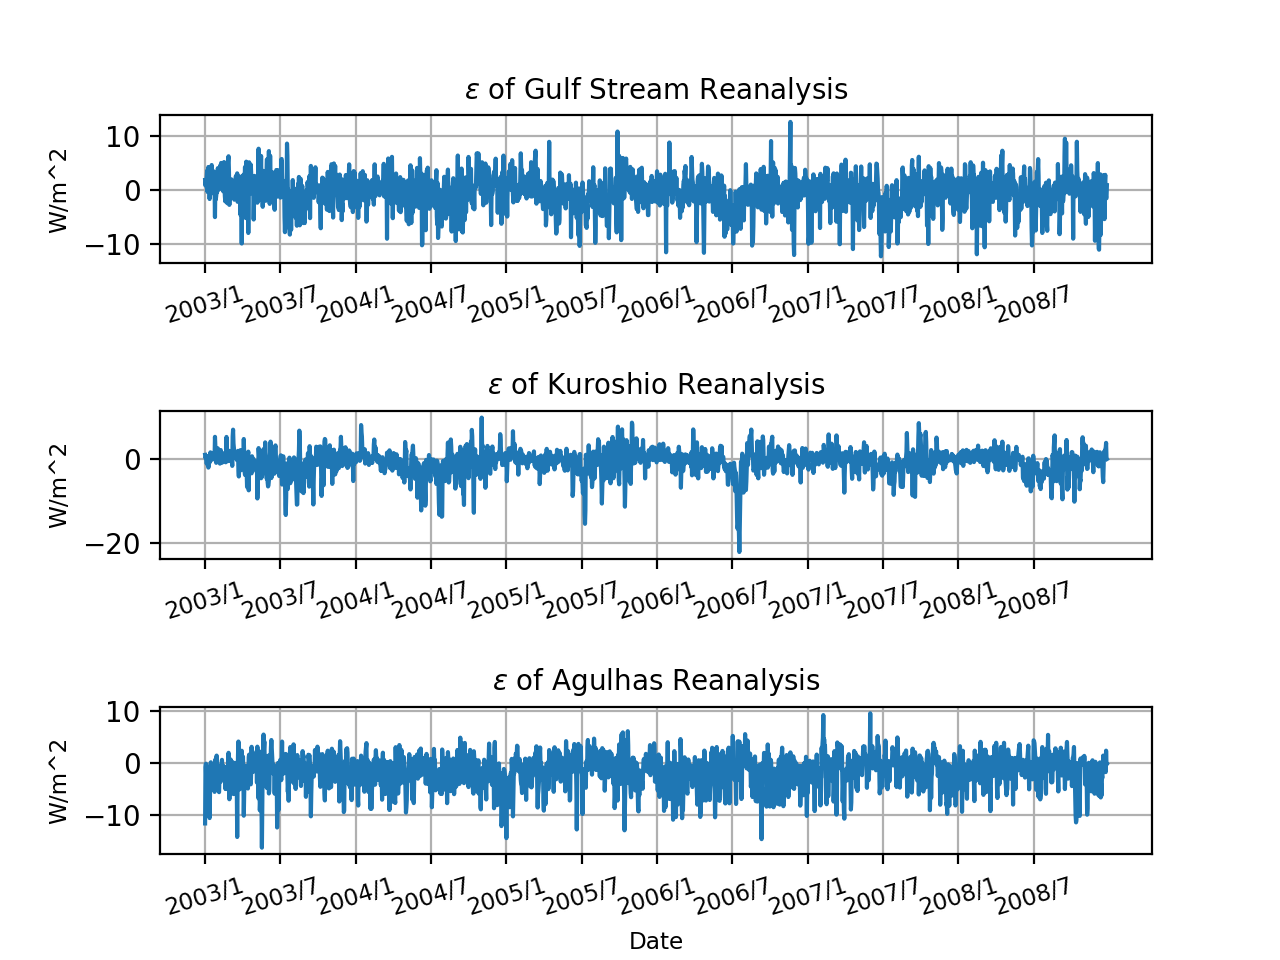

In [31]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(epsilon_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_title('$\epsilon$ of Gulf Stream Reanalysis',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(epsilon_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Kuroshio Reanalysis',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(epsilon_A,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$\epsilon$ of Agulhas Reanalysis',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()


## Daily Averages of Rectification

<IPython.core.display.Javascript object>


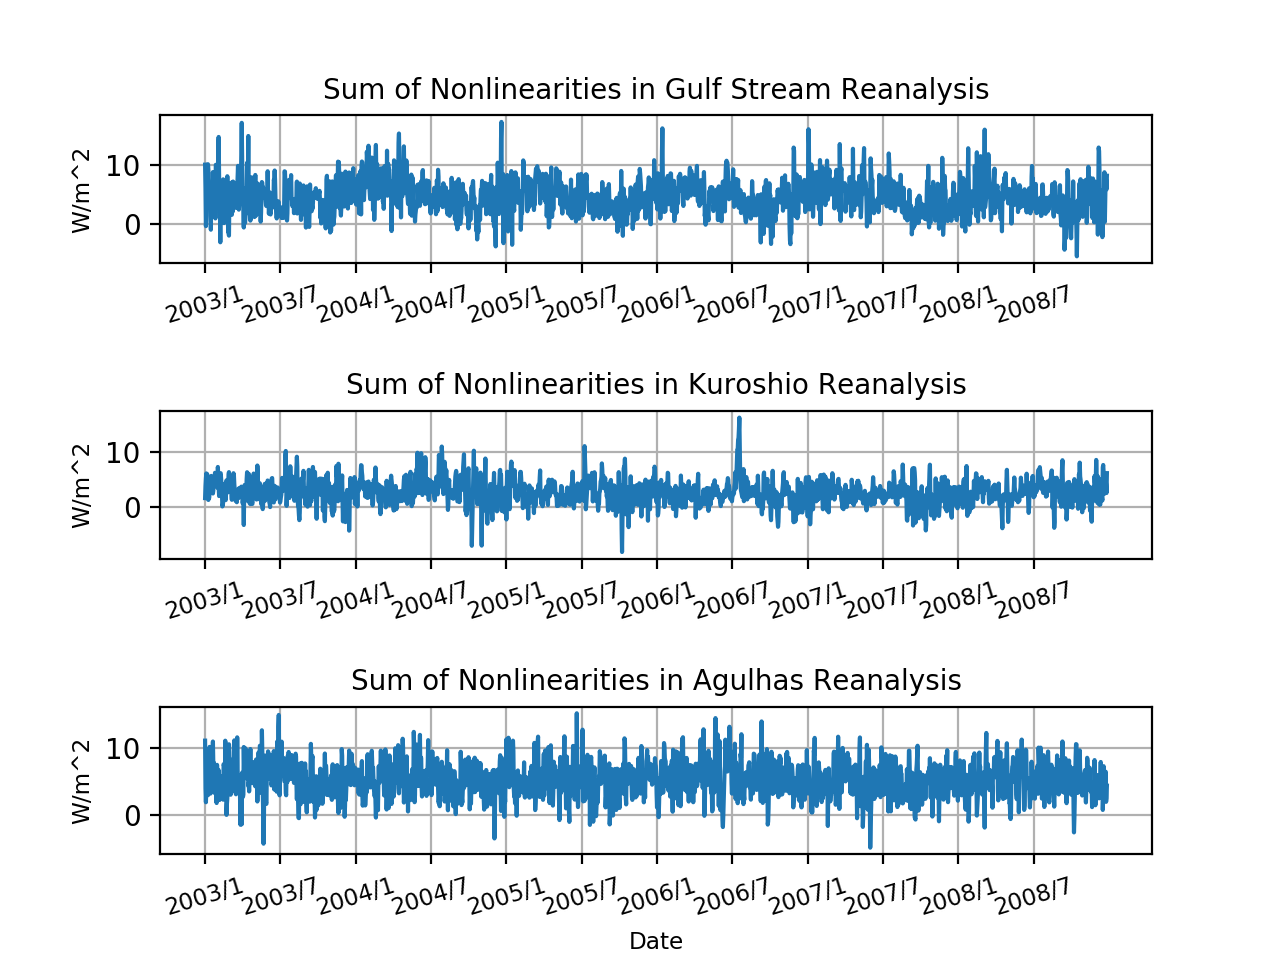

In [32]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(nonlin_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_title('Sum of Nonlinearities in Gulf Stream Reanalysis',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(nonlin_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('Sum of Nonlinearities in Kuroshio Reanalysis',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(nonlin_A,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('Sum of Nonlinearities in Agulhas Reanalysis',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=17,fontsize='small')
#ax.set_ylim([.5,8])
ax.grid()


<IPython.core.display.Javascript object>


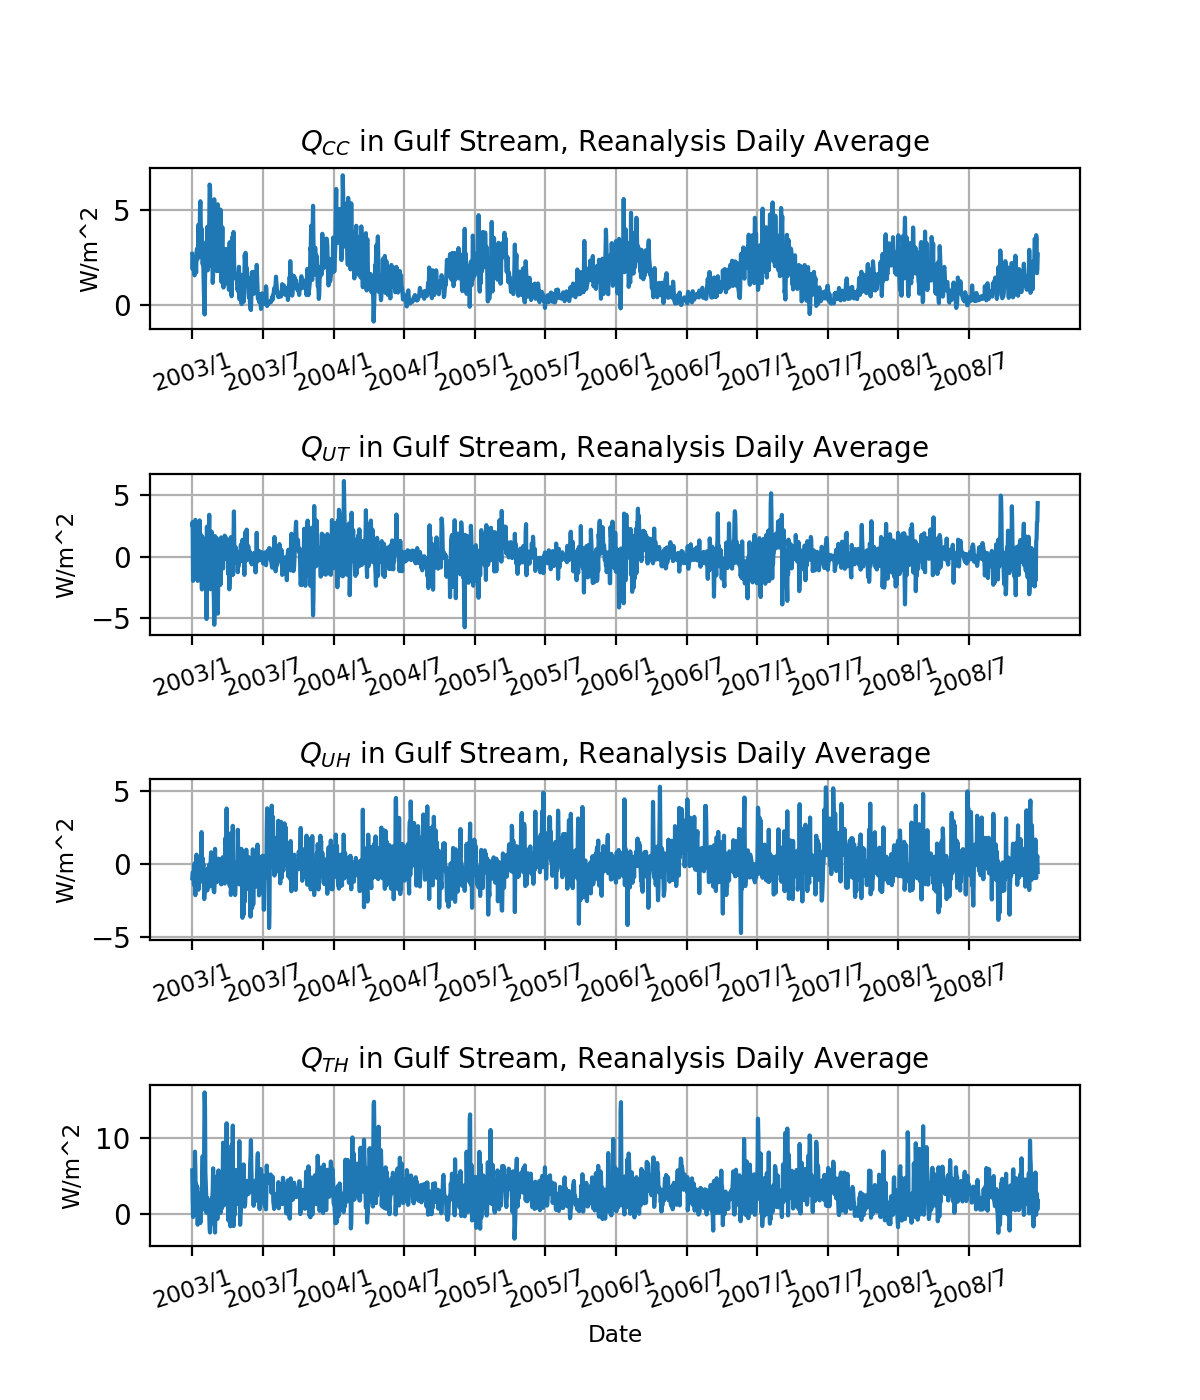

In [38]:
fig, axs = plt.subplots(nrows=4,figsize=(6,7))
fig.subplots_adjust(hspace=.9)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_title('$Q_{CC}$ in Gulf Stream, Reanalysis Daily Average',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([6,16])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q5_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UT}$ in Gulf Stream, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q6_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UH}$ in Gulf Stream, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Q7_GS,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{TH}$ in Gulf Stream, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()


<IPython.core.display.Javascript object>


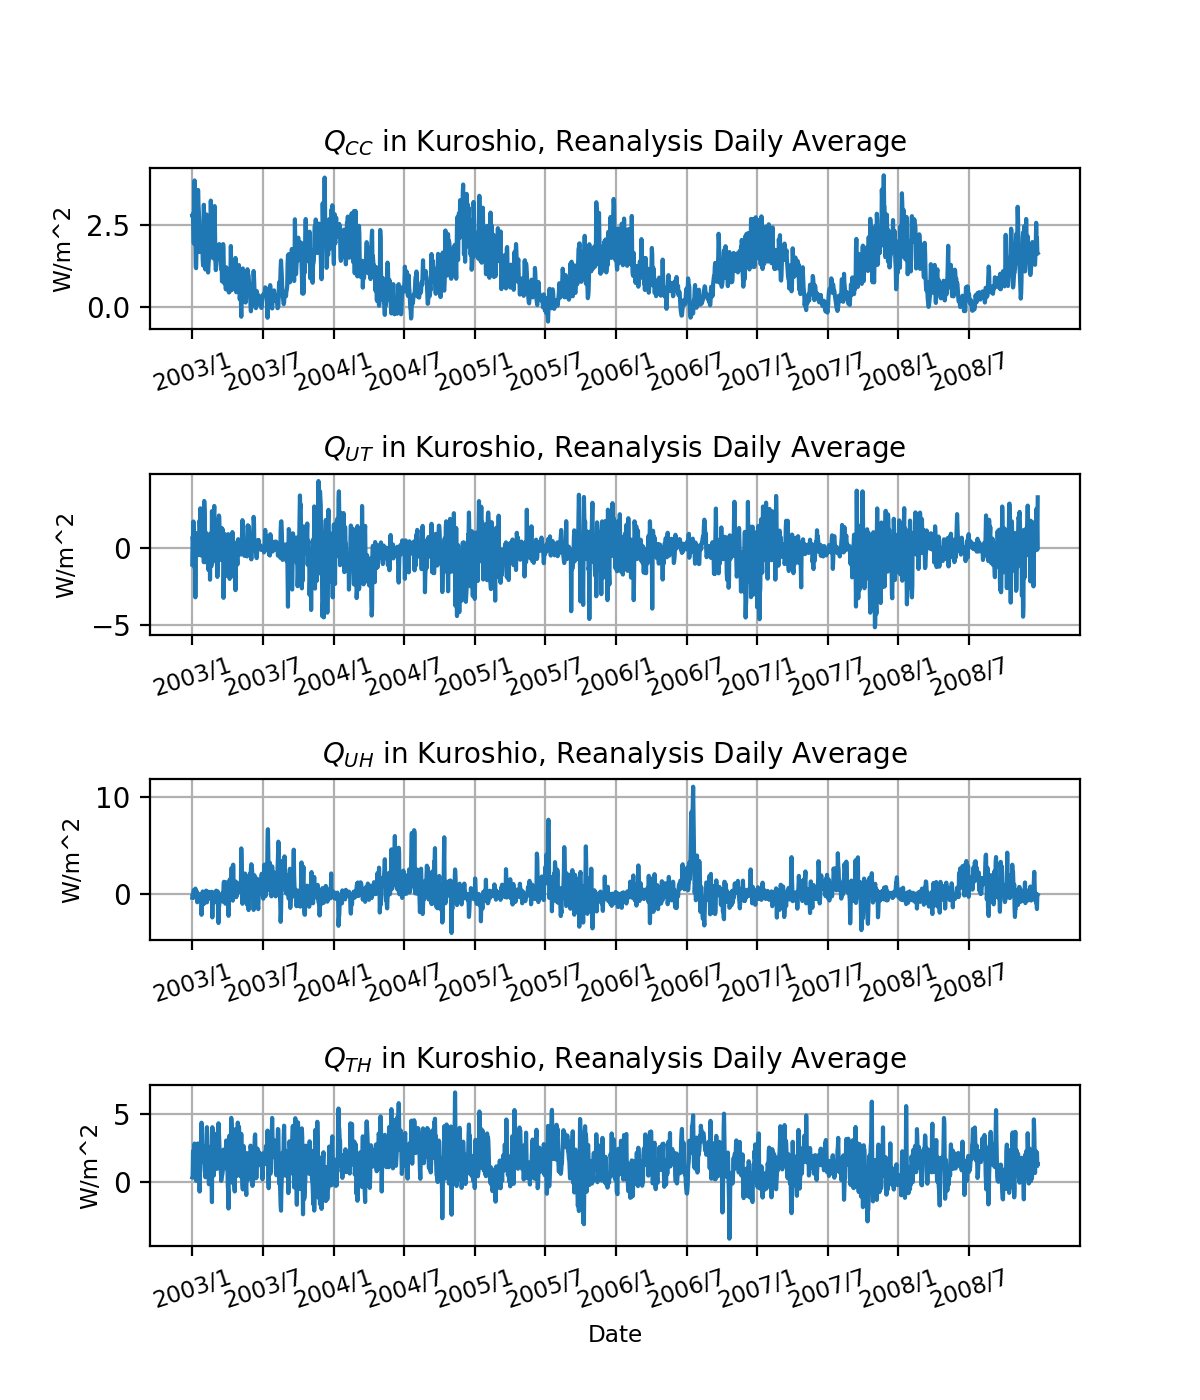

In [39]:
fig, axs = plt.subplots(nrows=4,figsize=(6,7))
fig.subplots_adjust(hspace=.9)

zero = np.zeros(len(time))

i = np.arange(0, len(time)+1, 183)
temp = np.array(t_str)
temp = temp[i]
yyyymm_str = ['2003/1','2003/7','2004/1','2004/7','2005/1','2005/7','2006/1','2006/7','2007/1','2007/7','2008/1','2008/7']


ax = axs[0]
ax.plot(t_str,np.nanmean(Q4_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_title('$Q_{CC}$ in Kuroshio, Reanalysis Daily Average',fontsize='medium')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([6,16])
ax.grid()

ax = axs[1]
ax.plot(t_str,np.nanmean(Q5_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UT}$ in Kuroshio, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
#ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[2]
ax.plot(t_str,np.nanmean(Q6_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{UH}$ in Kuroshio, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()

ax = axs[3]
ax.plot(t_str,np.nanmean(Q7_K,axis=(1,2)))
#ax.plot(t_str,zero)
ax.set_title('$Q_{TH}$ in Kuroshio, Reanalysis Daily Average',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(yyyymm_str, rotation=18,fontsize='small')
#ax.set_ylim([.85,1.13])
ax.grid()


# Monthly Average Rectification

In [40]:
Q4_mmeanGS, ym, m_str = monthly_avg(Q4_GS, day)
Q5_mmeanGS, _, _ = monthly_avg(Q5_GS, day)
Q6_mmeanGS, _, _ = monthly_avg(Q6_GS, day)
Q7_mmeanGS, _, _ = monthly_avg(Q7_GS, day)

Q4_mmeanK, _, _ = monthly_avg(Q4_K, day)
Q5_mmeanK, _, _ = monthly_avg(Q5_K, day)
Q6_mmeanK, _, _ = monthly_avg(Q6_K, day)
Q7_mmeanK, _, _ = monthly_avg(Q7_K, day)

Q4_mmeanA, _, _ = monthly_avg(Q4_A, day)
Q5_mmeanA, _, _ = monthly_avg(Q5_A, day)
Q6_mmeanA, _, _ = monthly_avg(Q6_A, day)
Q7_mmeanA, _, _ = monthly_avg(Q7_A, day)


<IPython.core.display.Javascript object>


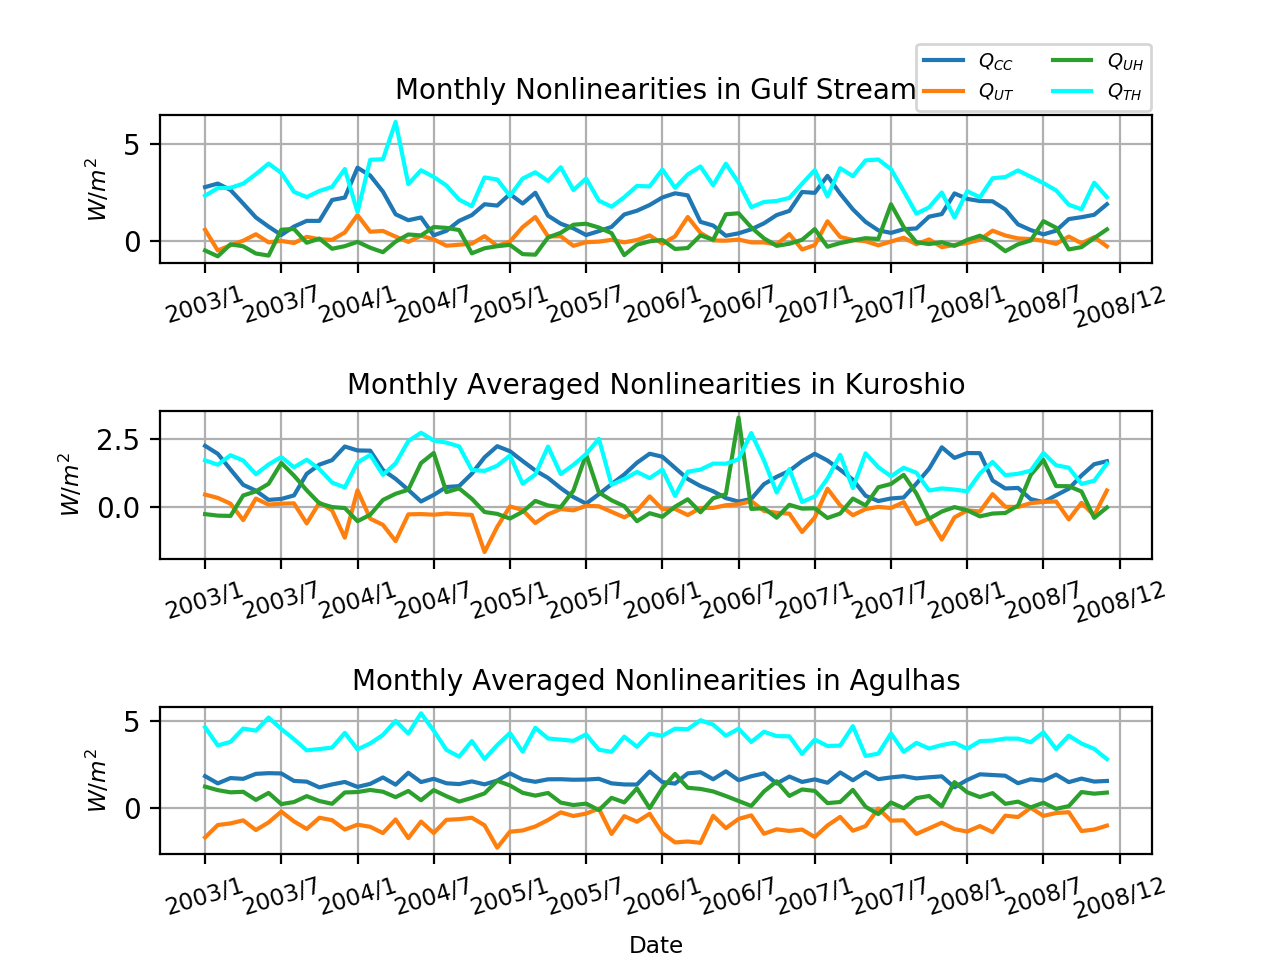

In [46]:
fig, axs = plt.subplots(nrows=3)
fig.subplots_adjust(hspace=1)

j = np.arange(0, len(m_str)+1, 6)
j[-1] = j[-1]-1
m_str_short = [m_str[j[a]] for a in range(len(j))]
i = np.arange(0, len(m_str)+1, 6)

ax = axs[0]
ax.plot(m_str,Q4_mmeanGS,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanGS,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanGS,label='$Q_{UH}$')
ax.plot(m_str,Q7_mmeanGS,label='$Q_{TH}$',color='cyan')
ax.legend(loc='upper right', fontsize='x-small',ncol=2,bbox_to_anchor=(1.009, 1.55))
ax.set_title('Monthly Nonlinearities in Gulf Stream',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
#ax.set_ylim([-7.5,8])
ax.grid()

ax = axs[1]
ax.plot(m_str,Q4_mmeanK,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanK,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanK,label='$Q_{UH}$')
ax.plot(m_str,Q7_mmeanK,label='$Q_{TH}$',color='cyan')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged Nonlinearities in Kuroshio',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
#ax.set_ylim([-7.5,8])
ax.grid()

ax = axs[2]
ax.plot(m_str,Q4_mmeanA,label='$Q_{CC}$')
ax.plot(m_str,Q5_mmeanA,label='$Q_{UT}$')
ax.plot(m_str,Q6_mmeanA,label='$Q_{UH}$')
ax.plot(m_str,Q7_mmeanA,label='$Q_{TH}$',color='cyan')
#ax.legend(loc='upper right', fontsize='x-small',ncol=1,bbox_to_anchor=(1.009, 1.4))
ax.set_title('Monthly Averaged Nonlinearities in Agulhas',fontsize='medium')
ax.set_ylabel('W/m^2',fontsize='small')
ax.set_xlabel('Date',fontsize='small')
ax.set_xticks(i)
ax.set_xticklabels(m_str_short, rotation=17,fontsize='small')
#ax.set_ylim([-7.5,8])
ax.grid()



# Functions for PDFS

In [47]:
def makehistcount(varr,varh,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    result counts the instances that data exists within the boxes
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        temp = varh[np.where((r[i] <= varr) & (r[i] + dr > varr))]
        
        for j in range(len(h)):
            
            hist[i,j] = np.count_nonzero((h[j] <= temp) & (h[j] + dh > temp))

    return r, h, hist


In [48]:
def makehistavg(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanmean(temp_varavg[idxh])

    return r, h, hist



In [49]:
def makehiststd(varr,varh,varavg,br,bh):
    '''
    r will be y-axis and h will be x-axis
    br and bh is the box size of the histogram
    results average the varavg 
    '''

    
    #create "boxes" that sort our histogram and will be the x and y axis when we plot
    #r = np.arange(np.floor(np.nanmin(varr)),np.floor(np.nanmax(varr)),dr)
    r = np.linspace(np.nanmin(varr),np.nanmax(varr),br)
    dr = (np.nanmax(varr)-np.nanmin(varr))/br
    h = np.linspace(np.nanmin(varh),np.nanmax(varh),bh)
    dh = (np.nanmax(varh)-np.nanmin(varh))/bh
    
    #create resulting histogram matrix that will be plotted
    hist = np.zeros([len(r),len(h)],dtype=float)

    i = 0
    j = 0
    for i in range(len(r)):
        
        idxr = np.where((r[i] <= varr) & (r[i] + dr > varr))
        temp_varh = varh[idxr]
        temp_varavg = varavg[idxr]        
        
        for j in range(len(h)):
            
            idxh = np.where((h[j] <= temp_varh) & (h[j] + dh > temp_varh))
            hist[i,j] = np.nanstd(temp_varavg[idxh])

    return r, h, hist


In [50]:
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

cdict3 = {'red':  ((0.0, 0.0, 0.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.8, 1.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 0.4, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (0.25, 0.0, 0.0),
                    (0.5, 0.9, 0.9),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 0.4),
                    (0.25, 1.0, 1.0),
                    (0.5, 1.0, 0.8),
                    (0.75, 0.0, 0.0),
                    (1.0, 0.0, 0.0))
          }

mpl.cm.register_cmap('BlueRed3',LinearSegmentedColormap('BlueRed3', cdict3))


# PDFS with Wind

In [51]:
r_GS4, h_GS4, hist_GS4 = makehistavg(wspdsm_GS,wdirsm_GS,Q4_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehistavg(wspdsm_GS,wdirsm_GS,Q5_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehistavg(wspdsm_GS,wdirsm_GS,Q6_GS,100,100)
r_GS7, h_GS7, hist_GS7 = makehistavg(wspdsm_GS,wdirsm_GS,Q7_GS,100,100)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


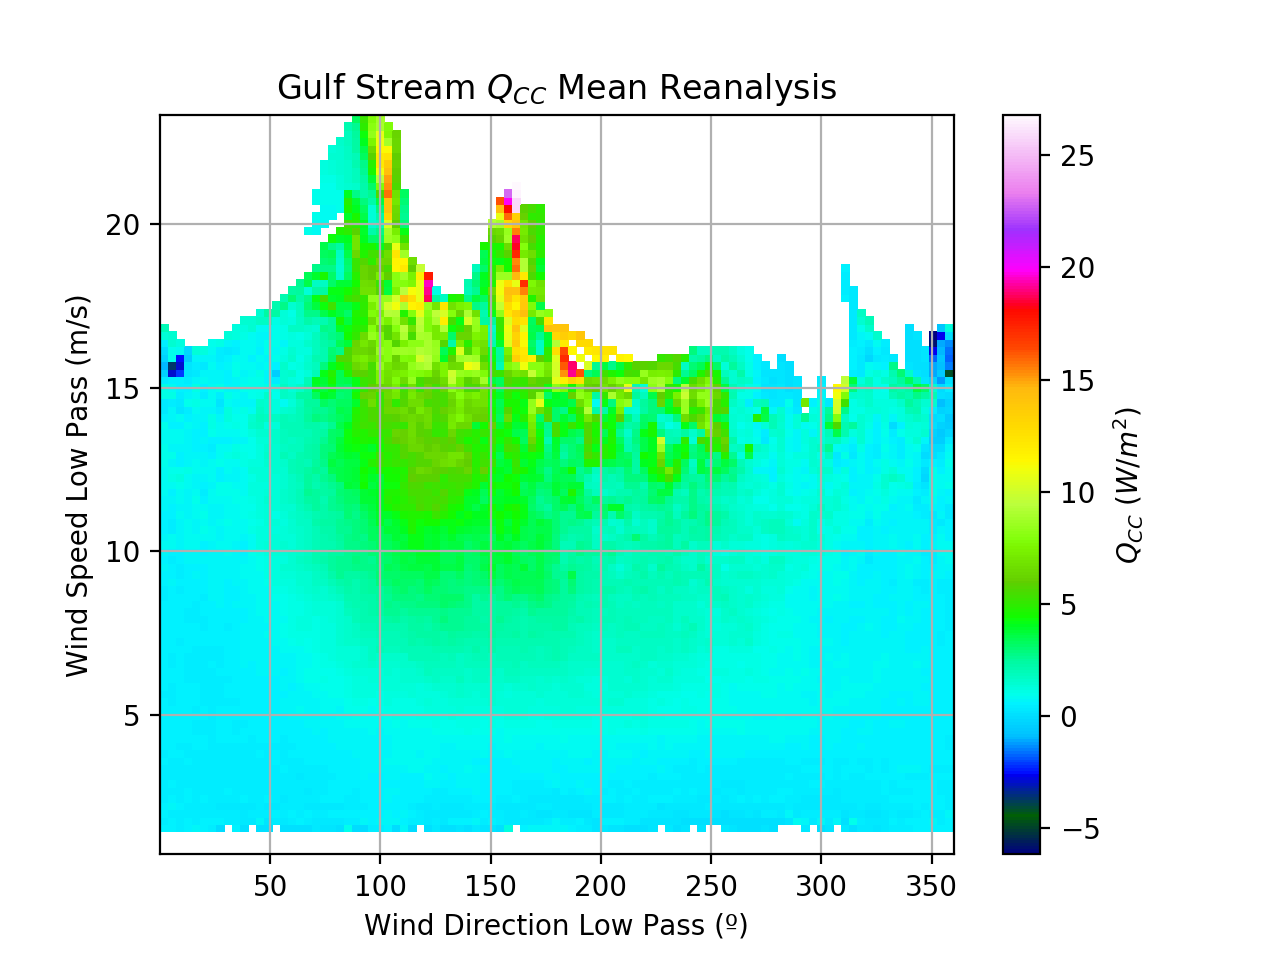

In [54]:
fig, ax = plt.subplots()

hist_GS4[np.where(hist_GS4 == 0.0)] = None

pc = ax.pcolormesh(h_GS4,r_GS4,hist_GS4,cmap='gist_ncar')#,vmin=0,vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{CC}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


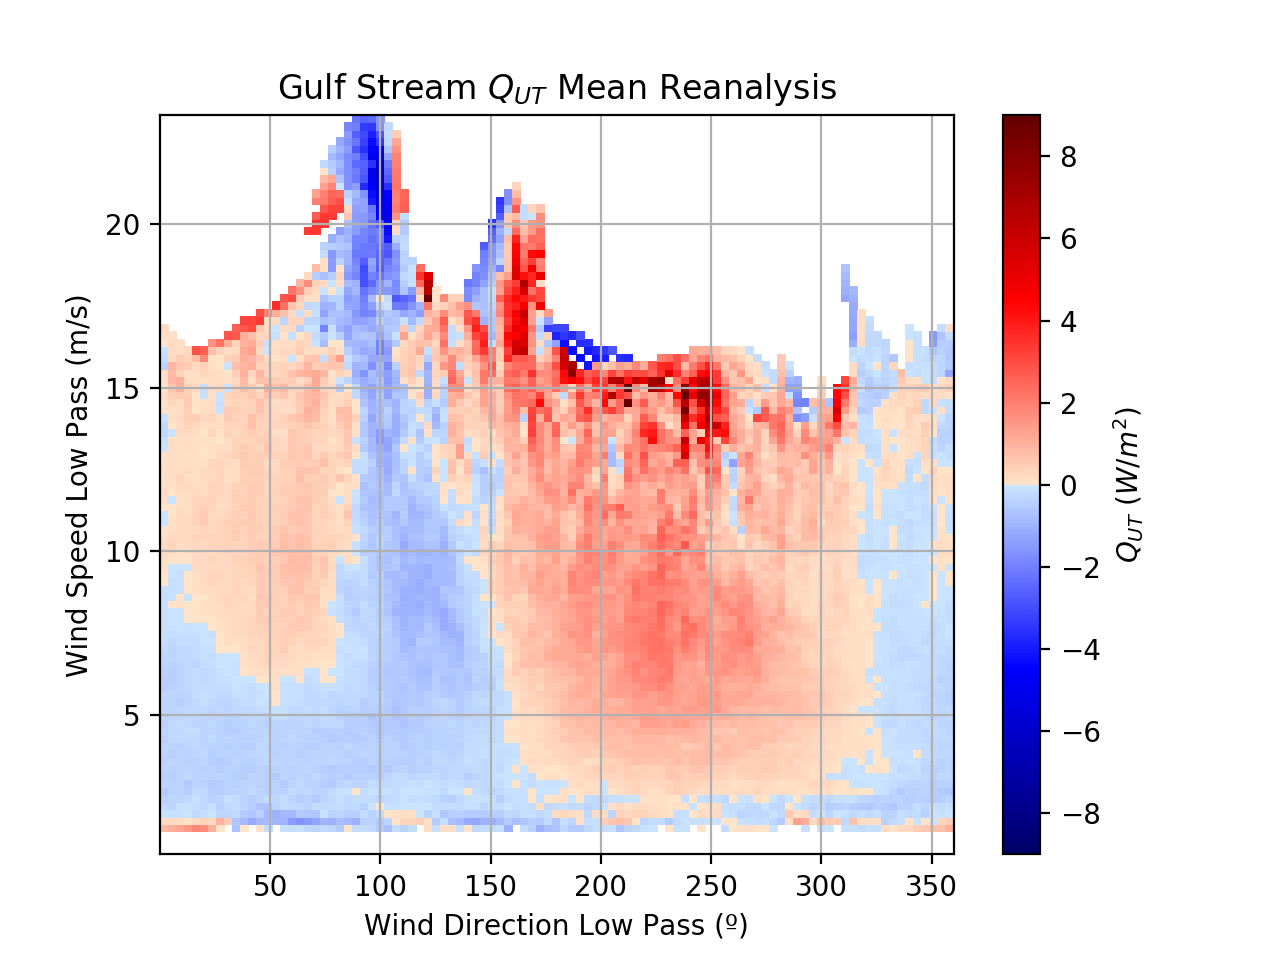

In [56]:
fig, ax = plt.subplots()

hist_GS5[np.where(hist_GS5 == 0.0)] = None

pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-9,vmax=9)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{UT}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


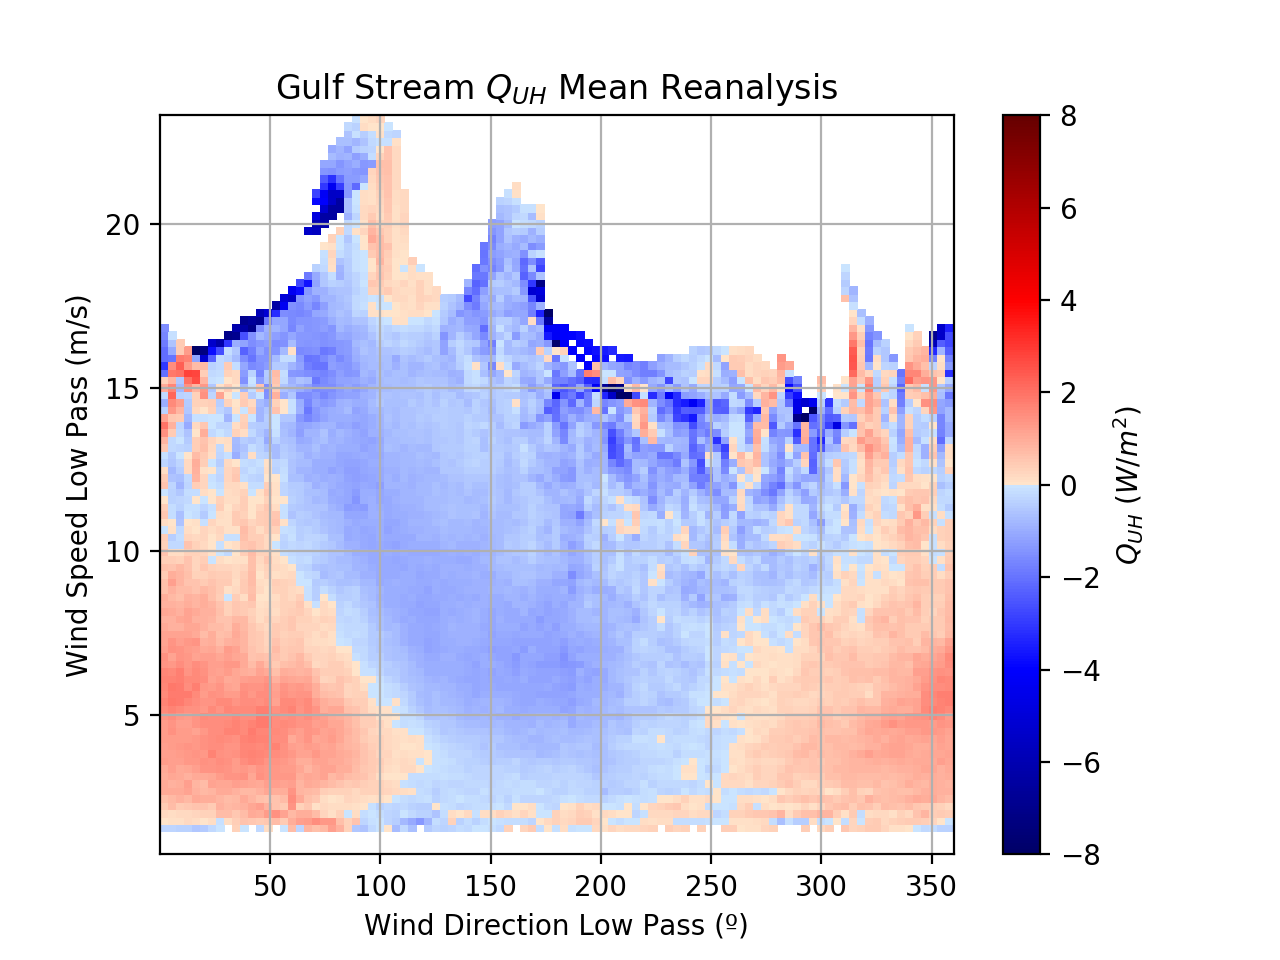

In [58]:
fig, ax = plt.subplots()

hist_GS6[np.where(hist_GS6 == 0.0)] = None

pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-8,vmax=8)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{UH}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


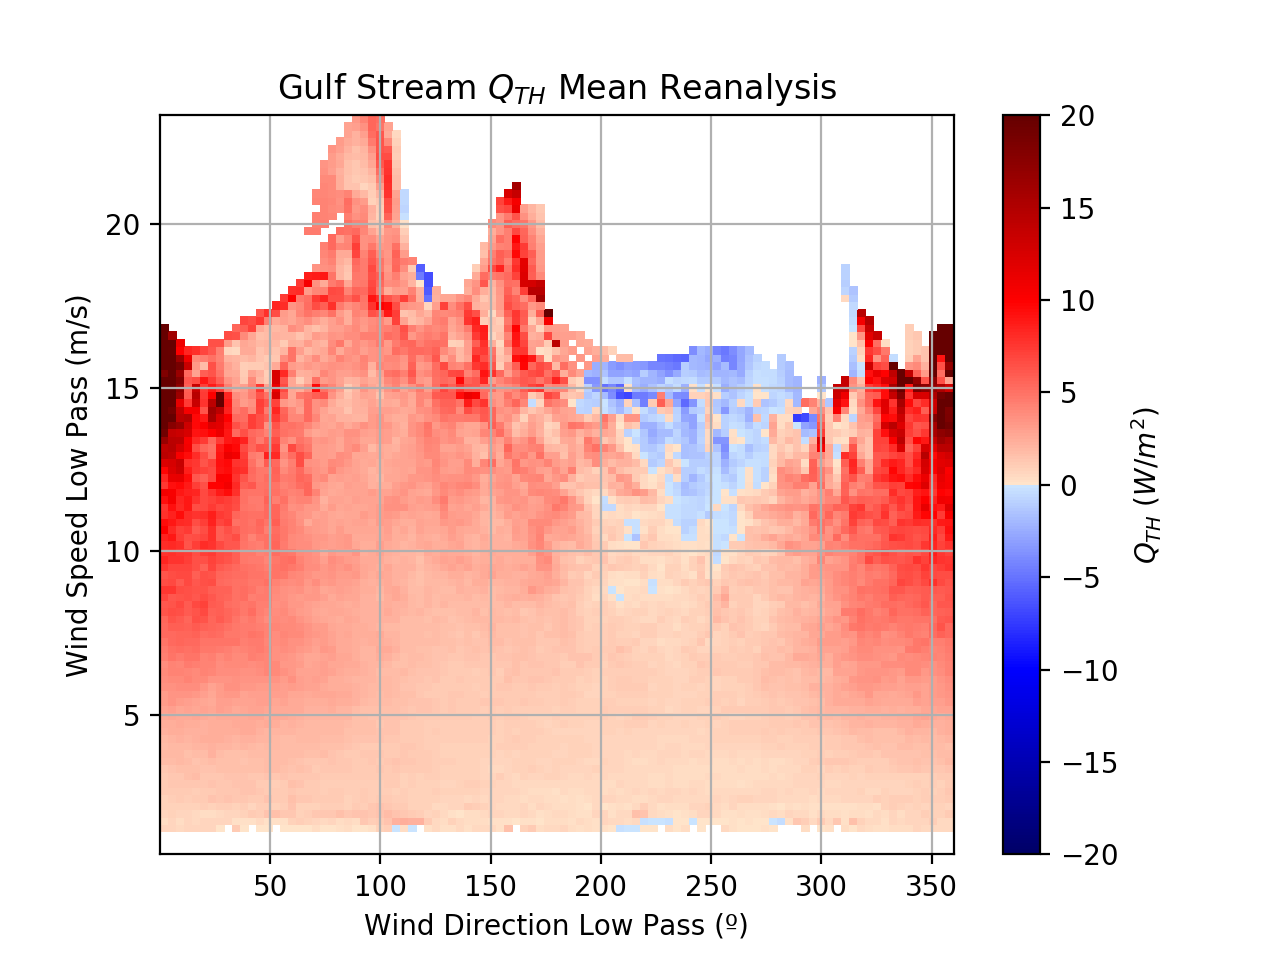

In [60]:
fig, ax = plt.subplots()

hist_GS7[np.where(hist_GS7 == 0.0)] = None

pc = ax.pcolormesh(h_GS7,r_GS7,hist_GS7,cmap='BlueRed3',vmin=-20,vmax=20)
fig.colorbar(pc,ax=ax,label="$Q_{TH}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TH}$ Mean Reanalysis")
ax.grid()


In [61]:
r_GS4, h_GS4, hist_GS4 = makehiststd(wspdsm_GS,wdirsm_GS,Q4_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehiststd(wspdsm_GS,wdirsm_GS,Q5_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehiststd(wspdsm_GS,wdirsm_GS,Q6_GS,100,100)
r_GS7, h_GS7, hist_GS7 = makehiststd(wspdsm_GS,wdirsm_GS,Q7_GS,100,100)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


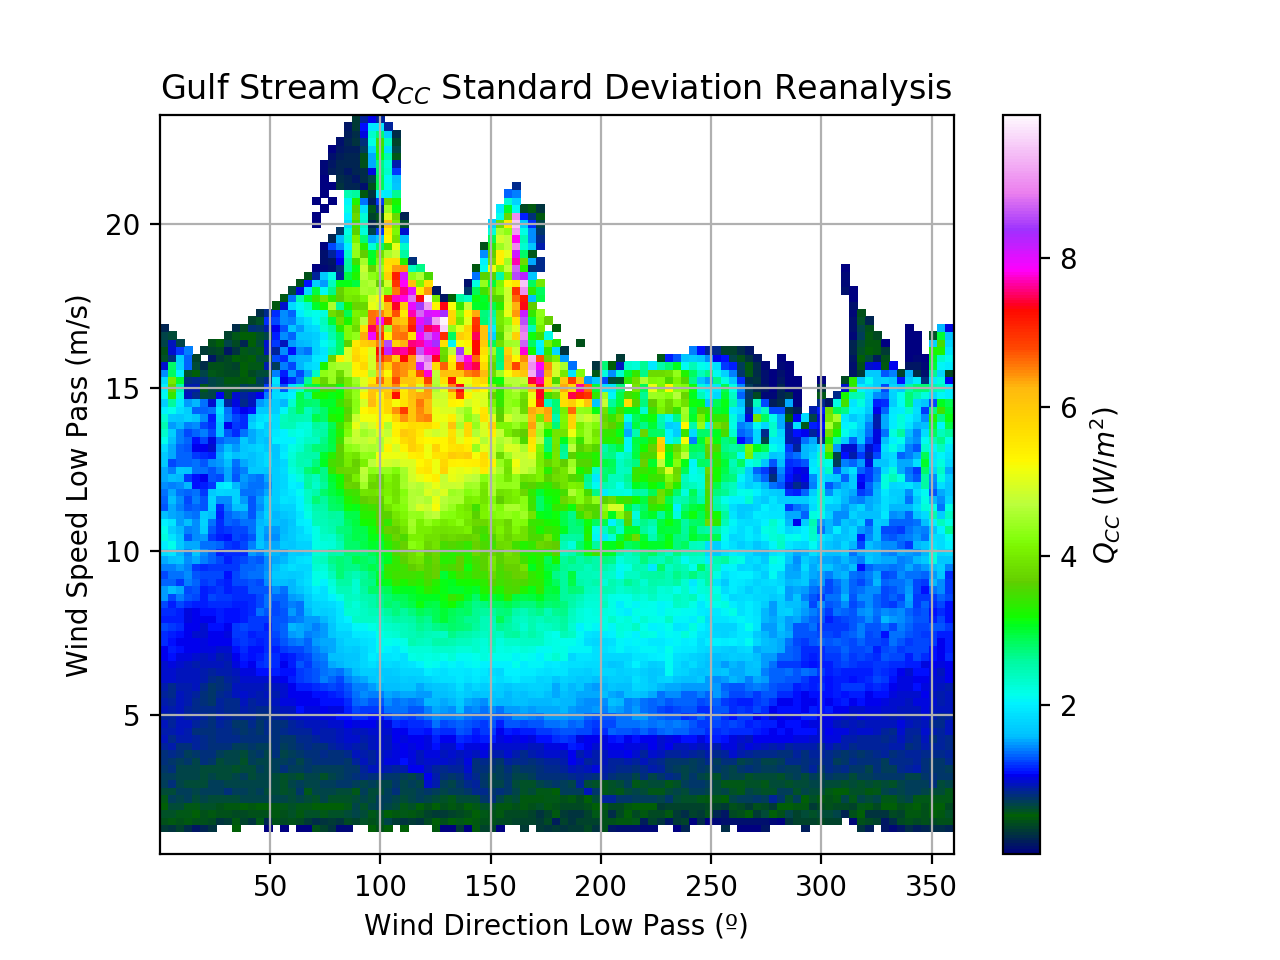

In [62]:
fig, ax = plt.subplots()

hist_GS4[np.where(hist_GS4 == 0.0)] = None

pc = ax.pcolormesh(h_GS4,r_GS4,hist_GS4,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{CC}$ Standard Deviation Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


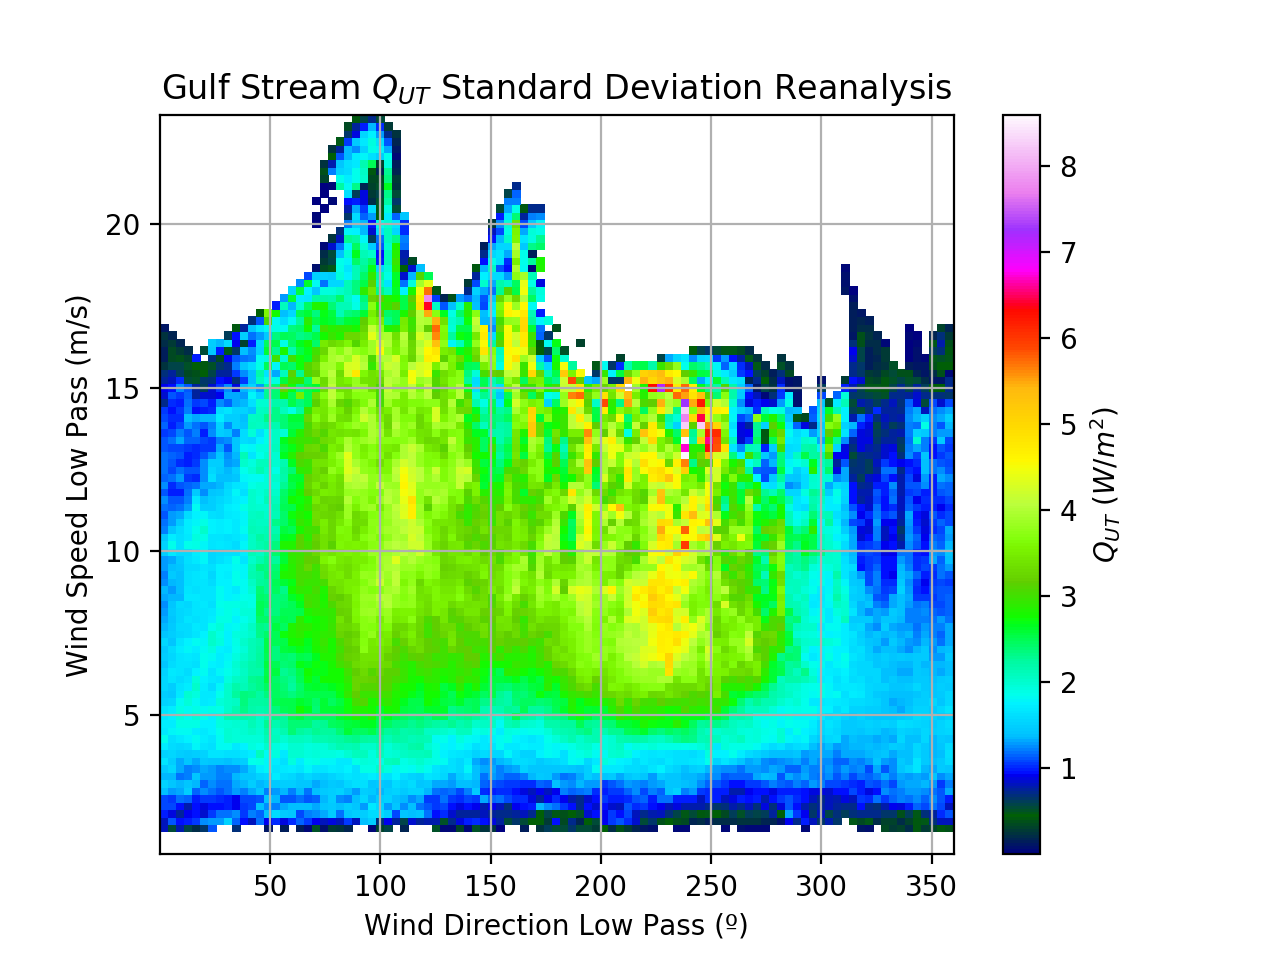

In [63]:
fig, ax = plt.subplots()

hist_GS5[np.where(hist_GS5 == 0.0)] = None

pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation Reanalysis")
ax.grid()

<IPython.core.display.Javascript object>


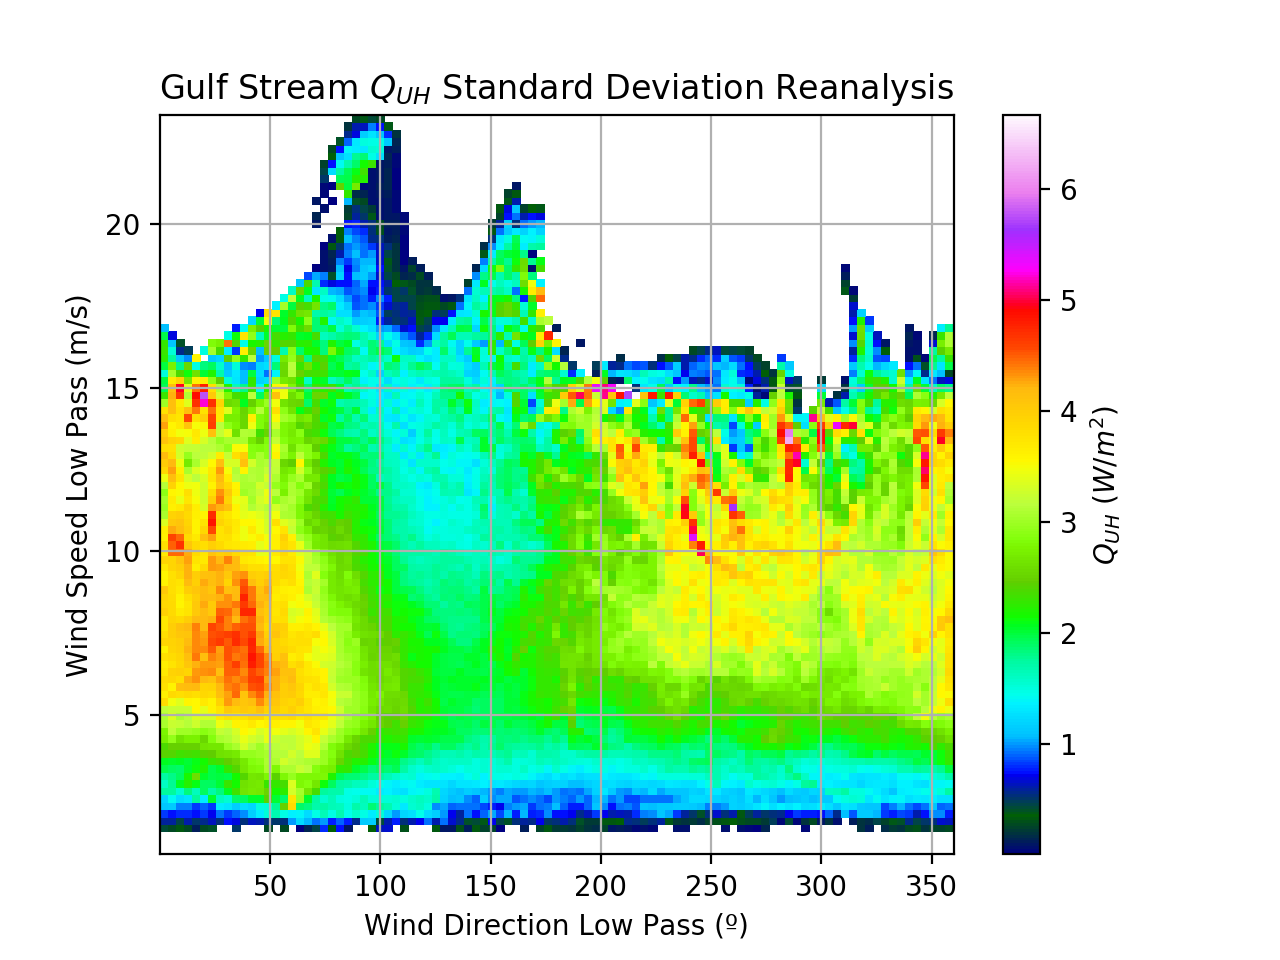

In [64]:
fig, ax = plt.subplots()

hist_GS6[np.where(hist_GS6 == 0.0)] = None

pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{UH}$ Standard Deviation Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


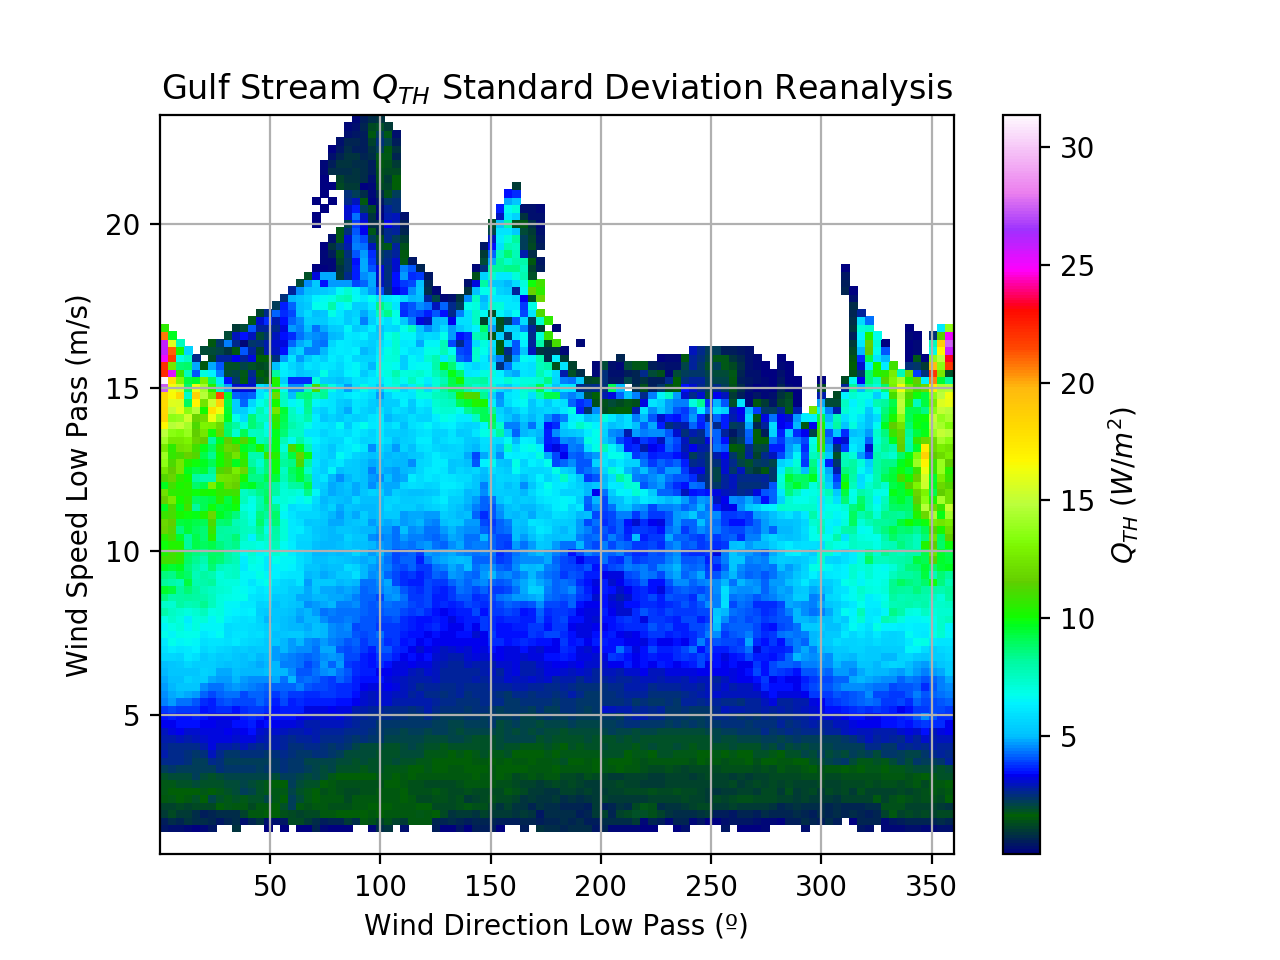

In [65]:
fig, ax = plt.subplots()

hist_GS7[np.where(hist_GS7 == 0.0)] = None

pc = ax.pcolormesh(h_GS7,r_GS7,hist_GS7,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{TH}$ (W/m^2)")
ax.set_xlabel("Wind Direction Low Pass (º)")
ax.set_ylabel("Wind Speed Low Pass (m/s)")
ax.set_title("Gulf Stream $Q_{TH}$ Standard Deviation Reanalysis")
ax.grid()


# PDF SST and Humidity

In [66]:
r_GS4, h_GS4, hist_GS4 = makehistavg(sstsm_GS,rhsm_GS,Q4_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehistavg(sstsm_GS,rhsm_GS,Q5_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehistavg(sstsm_GS,rhsm_GS,Q6_GS,100,100)
r_GS7, h_GS7, hist_GS7 = makehistavg(sstsm_GS,rhsm_GS,Q7_GS,100,100)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


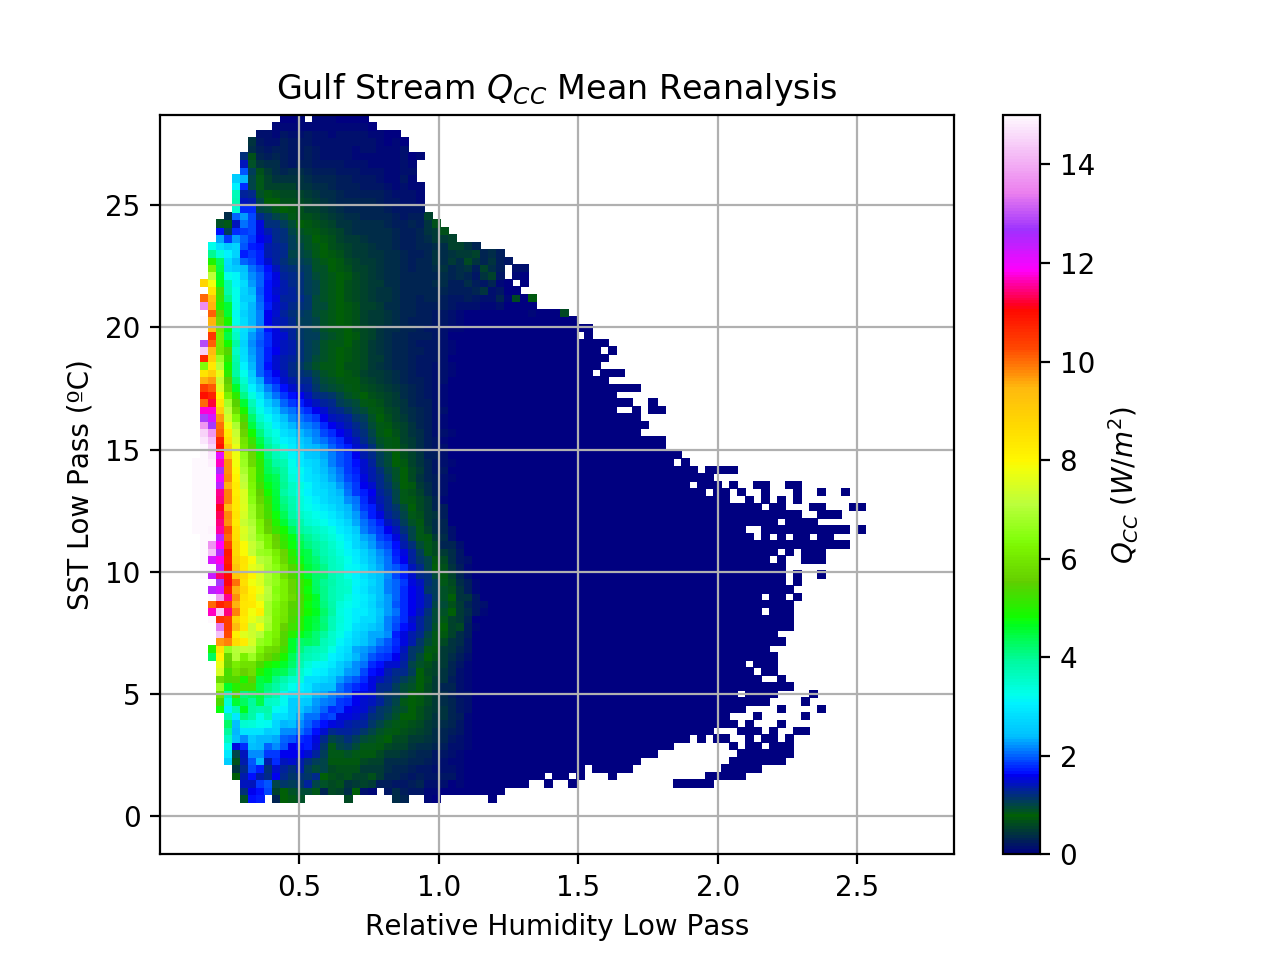

In [68]:
fig, ax = plt.subplots()

hist_GS4[np.where(hist_GS4 == 0.0)] = None

pc = ax.pcolormesh(h_GS4,r_GS4,hist_GS4,cmap='gist_ncar',vmin=0,vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{CC}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


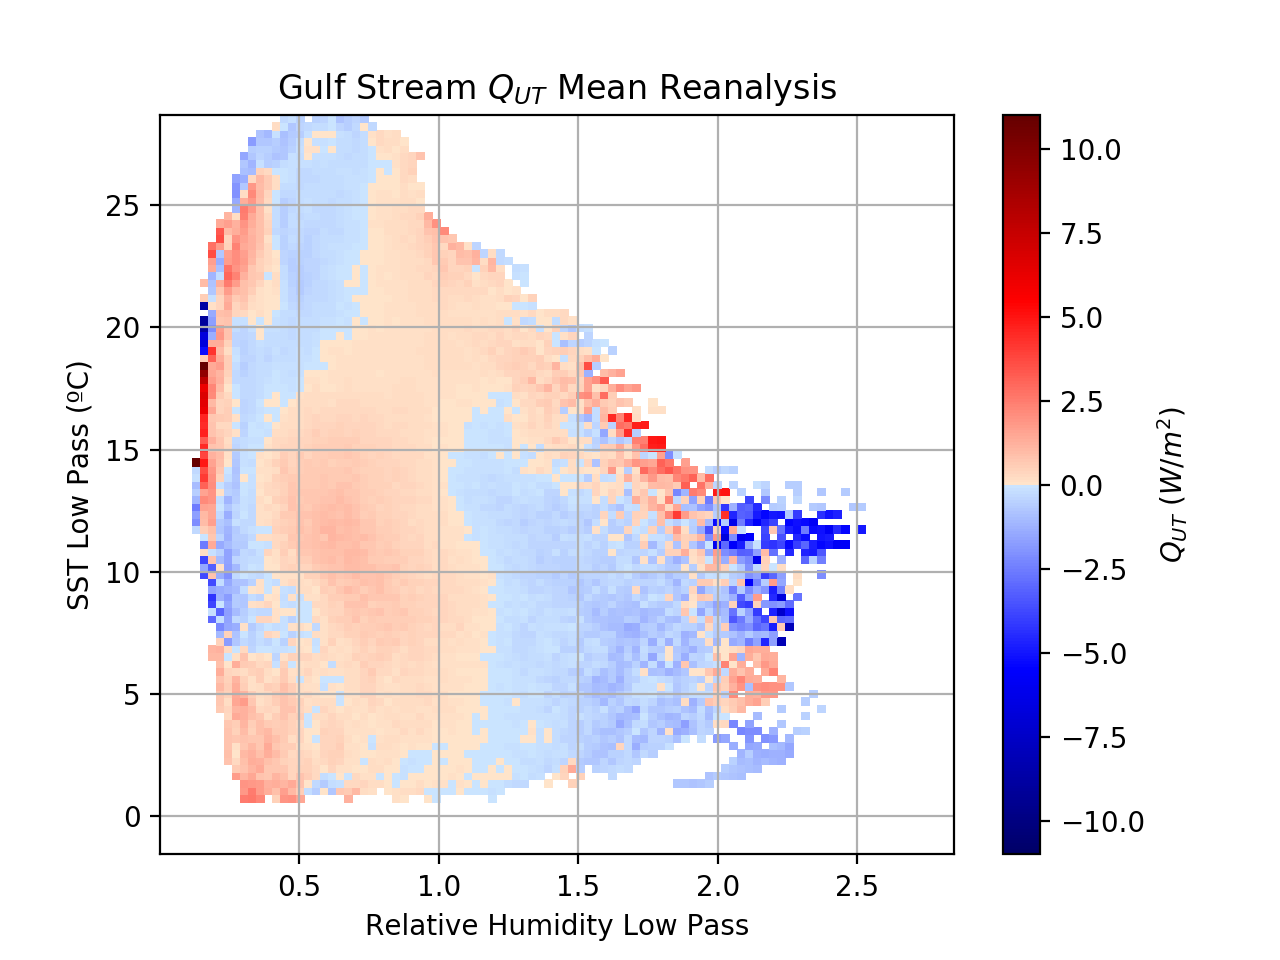

In [73]:
fig, ax = plt.subplots()

hist_GS5[np.where(hist_GS5 == 0.0)] = None

pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='BlueRed3',vmin=-11,vmax=11)
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


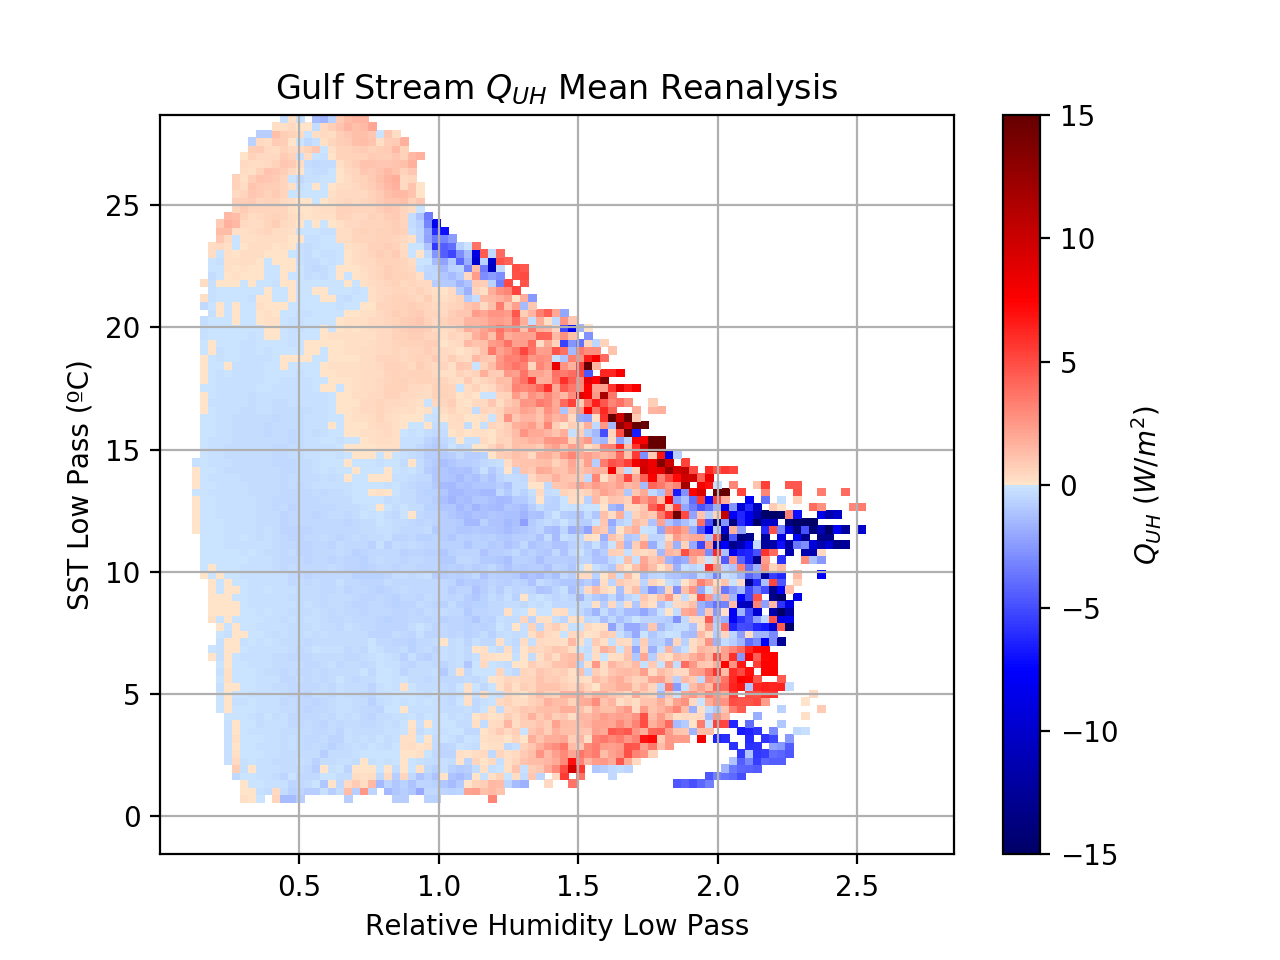

In [75]:
fig, ax = plt.subplots()

hist_GS6[np.where(hist_GS6 == 0.0)] = None

pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='BlueRed3',vmin=-15,vmax=15)
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UH}$ Mean Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


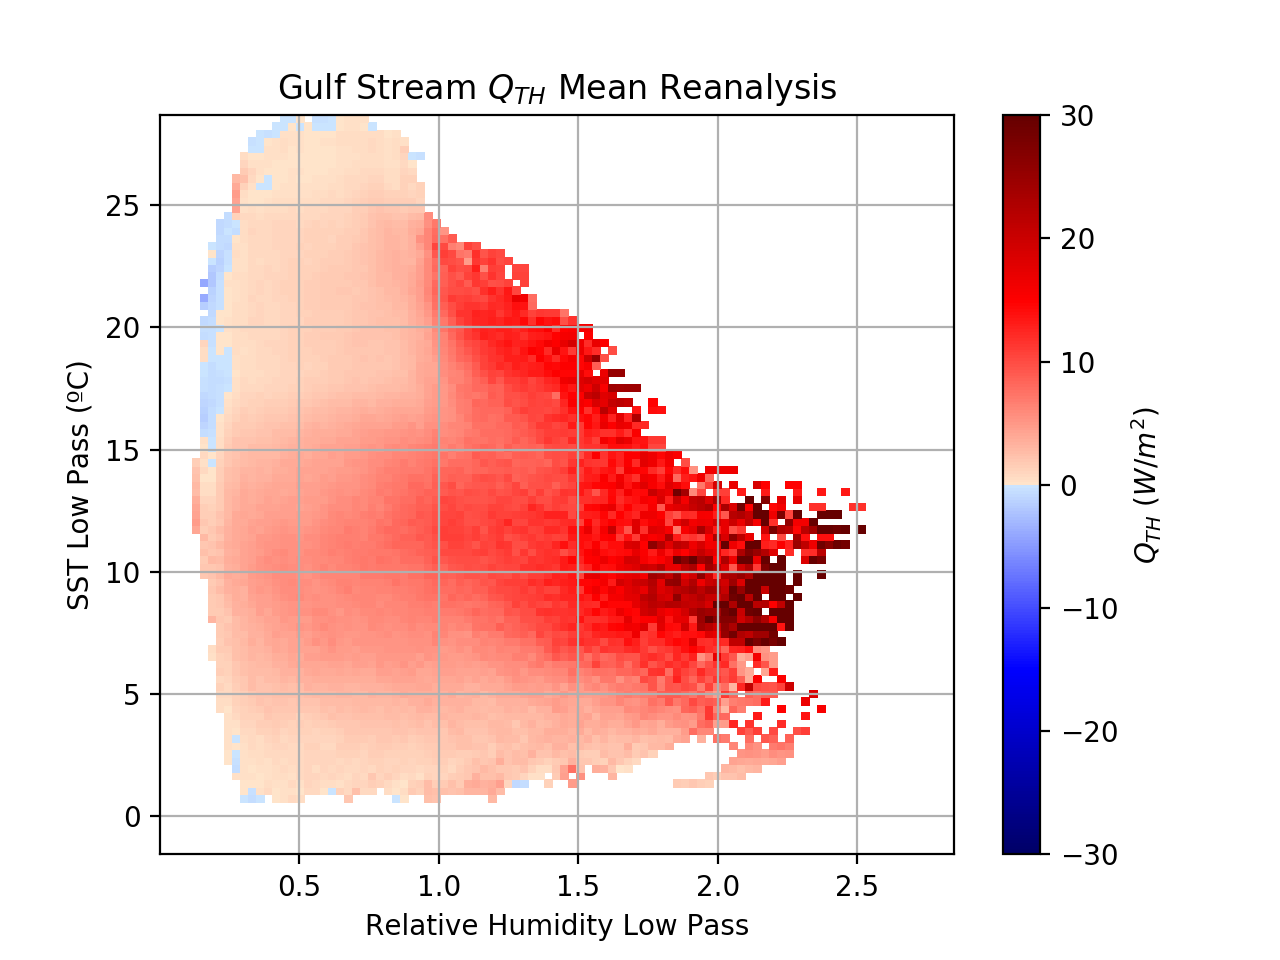

In [77]:
fig, ax = plt.subplots()

hist_GS7[np.where(hist_GS7 == 0.0)] = None

pc = ax.pcolormesh(h_GS7,r_GS7,hist_GS7,cmap='BlueRed3',vmin=-30,vmax=30)
fig.colorbar(pc,ax=ax,label="$Q_{TH}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TH}$ Mean Reanalysis")
ax.grid()


In [78]:
r_GS4, h_GS4, hist_GS4 = makehiststd(sstsm_GS,rhsm_GS,Q4_GS,100,100)
r_GS5, h_GS5, hist_GS5 = makehiststd(sstsm_GS,rhsm_GS,Q5_GS,100,100)
r_GS6, h_GS6, hist_GS6 = makehiststd(sstsm_GS,rhsm_GS,Q6_GS,100,100)
r_GS7, h_GS7, hist_GS7 = makehiststd(sstsm_GS,rhsm_GS,Q7_GS,100,100)

/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


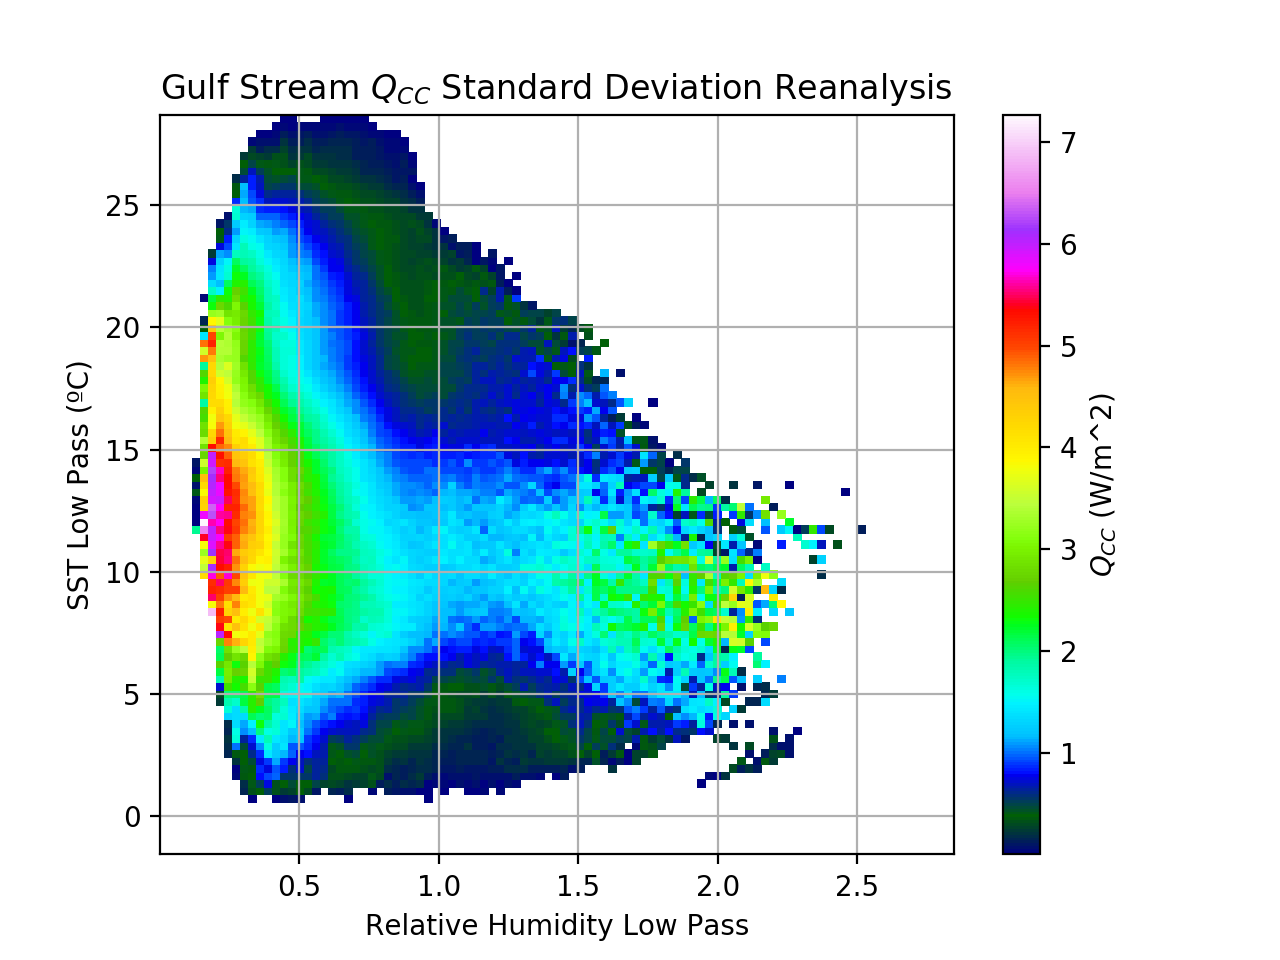

In [79]:
fig, ax = plt.subplots()

hist_GS4[np.where(hist_GS4 == 0.0)] = None

pc = ax.pcolormesh(h_GS4,r_GS4,hist_GS4,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{CC}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{CC}$ Standard Deviation Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


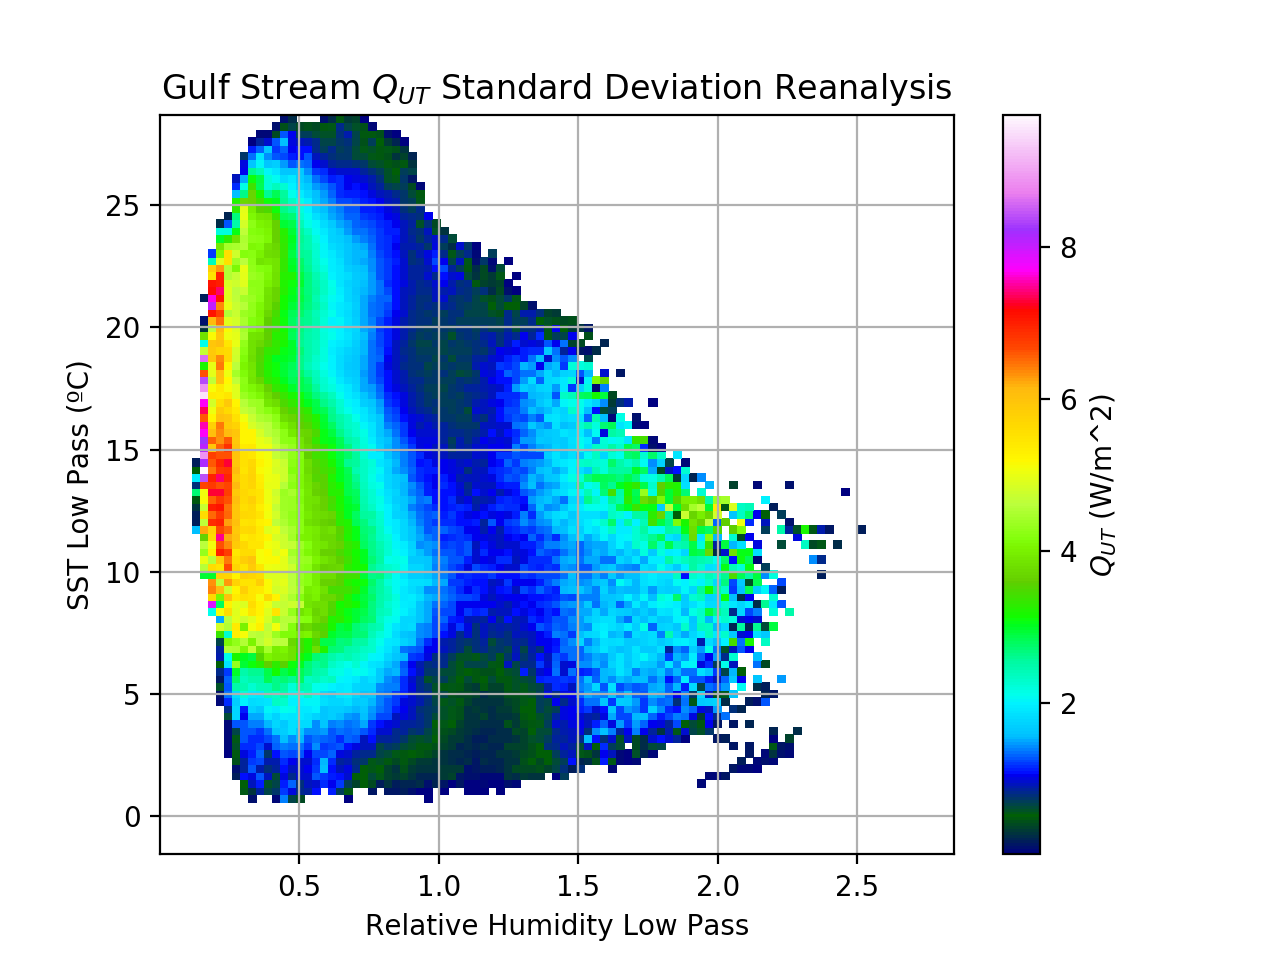

In [80]:
fig, ax = plt.subplots()

hist_GS5[np.where(hist_GS5 == 0.0)] = None

pc = ax.pcolormesh(h_GS5,r_GS5,hist_GS5,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UT}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UT}$ Standard Deviation Reanalysis")
ax.grid()


<IPython.core.display.Javascript object>


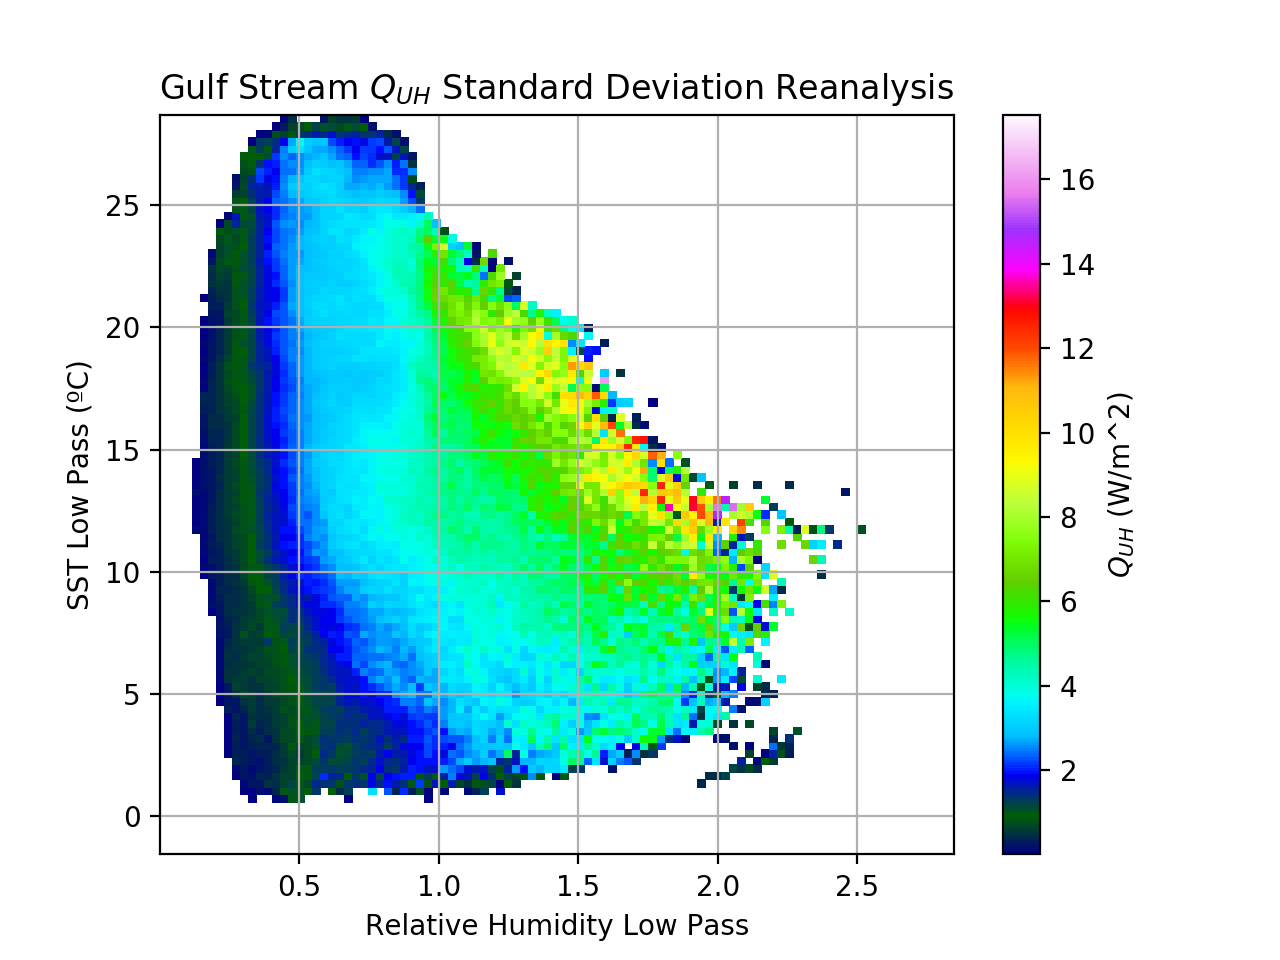

In [81]:
fig, ax = plt.subplots()

hist_GS6[np.where(hist_GS6 == 0.0)] = None

pc = ax.pcolormesh(h_GS6,r_GS6,hist_GS6,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{UH}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{UH}$ Standard Deviation Reanalysis")
ax.grid()


/Users/baileydonaldson/Python/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


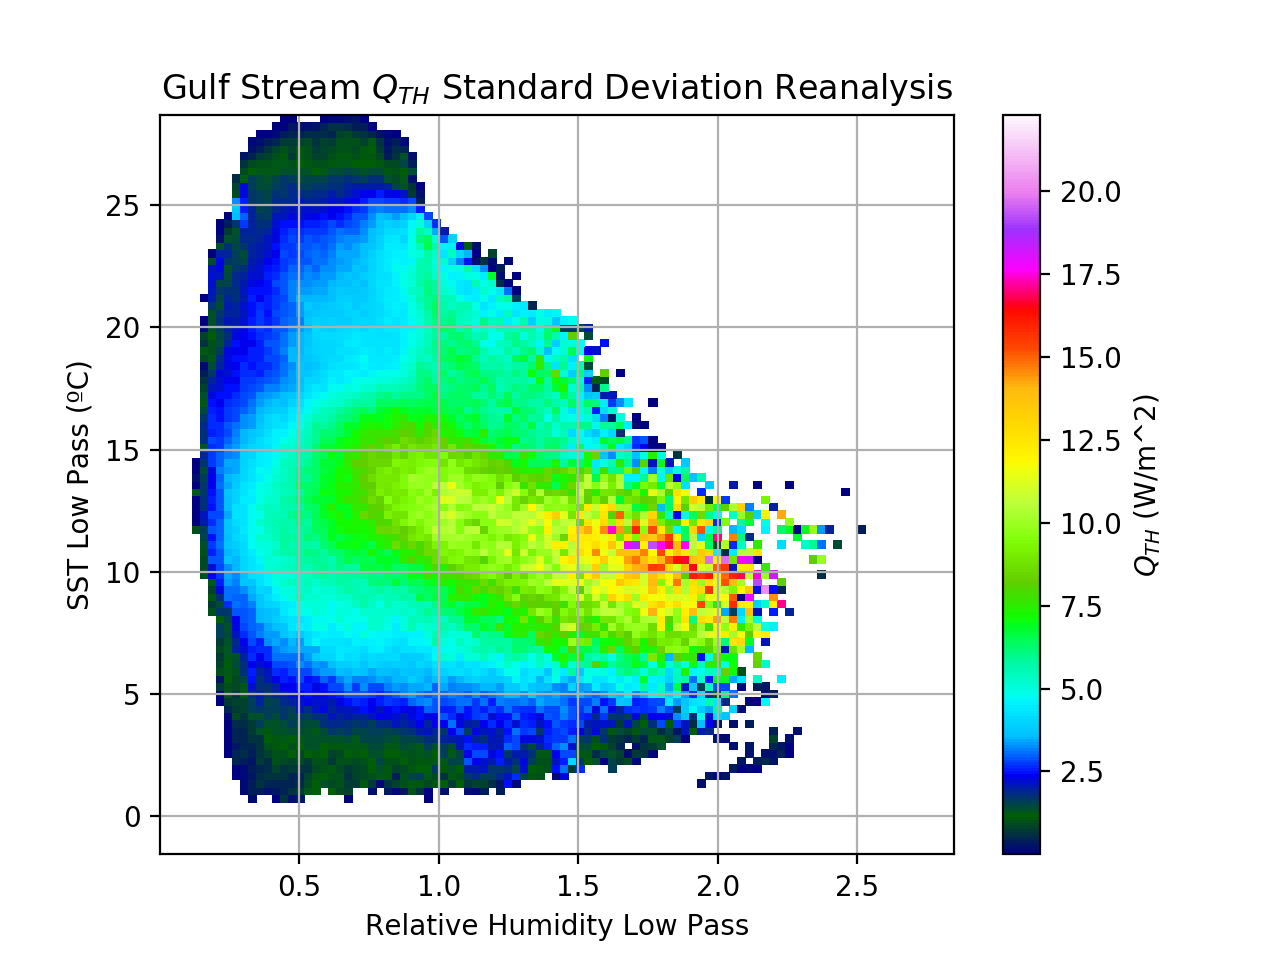

In [82]:
fig, ax = plt.subplots()

hist_GS7[np.where(hist_GS7 == 0.0)] = None

pc = ax.pcolormesh(h_GS7,r_GS7,hist_GS7,cmap='gist_ncar')
fig.colorbar(pc,ax=ax,label="$Q_{TH}$ (W/m^2)")
ax.set_xlabel("Relative Humidity Low Pass")
ax.set_ylabel("SST Low Pass (ºC)")
ax.set_title("Gulf Stream $Q_{TH}$ Standard Deviation Reanalysis")
ax.grid()
